In [1]:
%load_ext autoreload
%autoreload 2

import sys
from utils import *
from plotting import *
import calendar
import warnings
warnings.filterwarnings('ignore')
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
from rpy2.robjects import numpy2ri
numpy2ri.activate()
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import cartopy as cp
import rasterio as rio
import os
plt.rcParams['figure.figsize'] = [19, 12]

R[write to console]: data.table 1.13.6 using 4 threads (see ?getDTthreads).  Latest news: r-datatable.com

R[write to console]: 
Attaching package: ‘data.table’


R[write to console]: The following object is masked from ‘package:raster’:

    shift




The notebook is structured in the following sections in order:
- Various configurations of the grass crop model
- Calculation of the AWC (Available Water Content) for China
- Various configurations of the wheat crop model
- Production of the irrigation and crop maps
- Computation of the climatologies and anomalies
- Plotting of the anomaly animations
- Other plots that might be useful
- Various plots of the wheat crop model for reference

The configurations of the crop model are mostly just different driving data, but some also where irrigation etc. is enabled/disabled. 
You will have to change the paths to the various files used if you move stuff from my directories.
Other than that, pick a configuration closest to the one you need, make the appropriate edits to the config/switches and run. The setup at the bottom of the 'Wheat model runs' section is the one that I have annotated a bit more than the others.

### Grass model runs

#### Grass model (grid, era5)

In [20]:
startyear = 2015
startmonth = 1
startday = 1
endyear = 2015
endmonth = 12
endday = 30

downloaddata = 0 ## NOT SURE IF THIS BIT STILL WORKS
latmax = 54.875 # only used if downloaddata == 1
lonmin = 60.125
latmin = -14.875
lonmax = 149.875

dataloc = "/prj/verdant/matbro/data/driving_china/*.nc"
saveloc = '/prj/verdant/matbro/data/grass_driving_china/'
#elevfile = '/prj/verdant/matbro/data/NextMap_DTM_50m.tif'
CO2file = '/prj/verdant/matbro/data/UKCP18_CO2_RCP85.csv'
simx = '01'
crop = 'grass'
xdimname = 'longitude'
ydimname = 'latitude'
datasetname = 'era5'
mask = 1

In [22]:
startmonthstr = '{:02.0f}'.format(startmonth)
startdaystr = '{:02.0f}'.format(startday)
endmonthstr = '{:02.0f}'.format(endmonth)
enddaystr = '{:02.0f}'.format(endday)

# extract out a year's worth of obs
# TODO adapt to handle non-360day calendars
# can use days_in_month code from PET project
if basedatasetname=='ukcp18' or basedatasetname=='ukcp18bc':
    ctype = '360_day'
else:
    ctype = 'gregorian'
gyeardates = xr.cftime_range(str(startyear) + '-' + startmonthstr + '-' + startdaystr,
                             str(endyear) + '-' + endmonthstr + '-' + enddaystr,
                             calendar=ctype, freq='D', name='date').values

print('Running for ' + str(gyeardates[0]) + ' to ' + str(gyeardates[-1]))

times = np.array([str(t.year)+'{:02.0f}'.format(t.month)+'{:02.0f}'.format(t.day) for t in list(gyeardates)])

dd = load_driving_data(datasetname, times, dataloc, saveloc, simx, crop, 
                       CO2file=CO2file, mask=mask, downloaddata=downloaddata, 
                       lonmin=lonmin, lonmax=lonmax, latmin=latmin, latmax=latmax)

tmean = dd['tmean']
tmax  = dd['tmax']
tmin  = dd['tmin']
prec  = dd['prec']
tdp   = dd['tdp']
wind  = dd['wind']
sfcP  = dd['sfcP']
solarrad = dd['solarrad']
x = dd['x']
y = dd['y']
t = dd['t']
cconc = dd['cconc']

r['source']('Grass_potpredict_MJB.R')
grassfunc = r['grass_py']
print('Running grass model')
datalist = grassfunc(tmean, tmax, tmin, prec, solarrad, tdp, wind,
                     x, y, t, datasetname, cconc=cconc, sfcP=sfcP)

PET = np.array(datalist.rx2('PET'))
AET = np.array(datalist.rx2('AET'))
SMD = np.array(datalist.rx2('SMD'))
Yp  = np.array(datalist.rx2('Yp'))
Ya  = np.array(datalist.rx2('Ya'))
EaEp = np.array(datalist.rx2('EaEp'))
RUE    = np.array(datalist.rx2('RUE'))
preRUE = np.array(datalist.rx2('preRUE'))
Rr  = np.array(datalist.rx2('Rr'))
Tt  = np.array(datalist.rx2('Tt'))
#TtX = np.array(datalist.rx2('TtX'))
x2   = np.array(datalist.rx2('x'))
e    = np.array(datalist.rx2('e'))
YaSum = np.array(datalist.rx2('YaSum'))
print(YaSum[50,50])

Running for 2015-01-01 00:00:00 to 2015-12-30 00:00:00
Producing subsetted driving data nc file(s):
Driving data file already exists, skipping generation
Reading in driving data from file
Processing data into format ready for model
Reading in prec
Reading in tmax
Reading in tmin
Reading in tdp
Reading in solarrad
Reading in uwind
Reading in vwind
Reading in tmean
Reading in sfcP
Done
Passing data to model
Running grass model
[1] "using"
[1] "era5"
[1] "Converting rad units from J/m^2/day --> MJ/m^2/day"
[1] "Using sfcP"
0.0


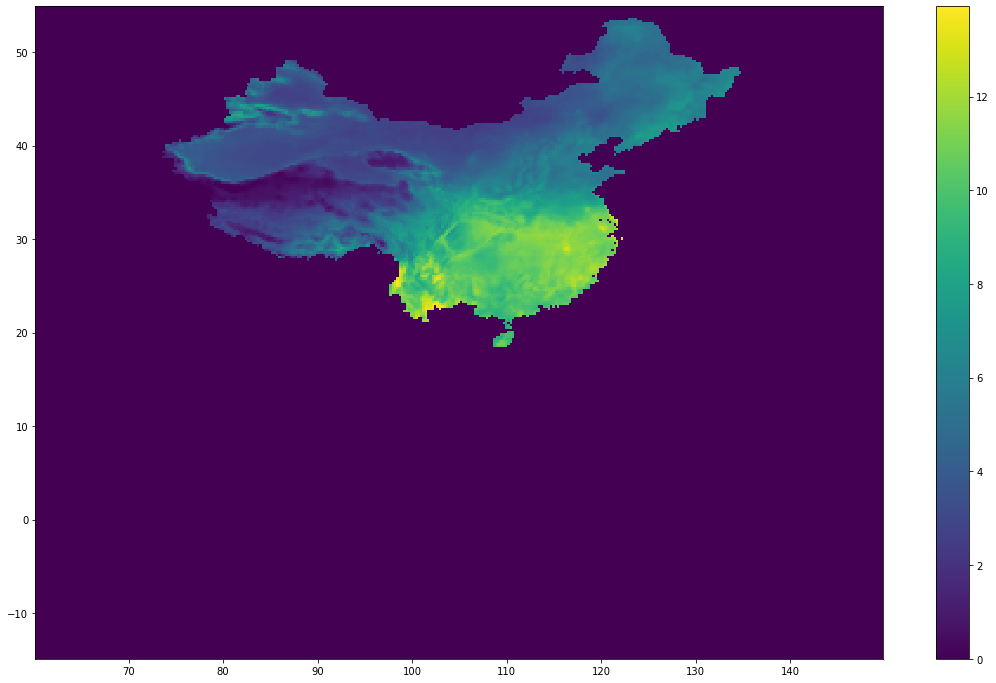

In [24]:
plt.pcolormesh(x, y, YaSum[:,:])
plt.colorbar()

#### Grass model (grid, era5+aphrodite)

In [30]:
startyears = np.arange(1990, 2015)
startmonth = 1
startday = 1
endyears = np.arange(1990, 2015)
endmonth = 12
endday = 31

downloaddata = 0
latmax = 54.875 # only used if downloaddata == 1
lonmin = 60.125
latmin = -14.875
lonmax = 149.875

dataloc = "/prj/verdant/matbro/data/driving_china/*.nc"
saveloc = '/prj/verdant/matbro/data/grass_driving_china/netcdf'
outloc  = '/prj/verdant/matbro/outputs/yields'
#elevfile = '/prj/verdant/matbro/data/NextMap_DTM_50m.tif'
CO2file = '/prj/verdant/matbro/data/UKCP18_CO2_RCP85.csv'
simx = '01'
crop = 'grass'
basedatasetname = 'era5'
precipname = 'aphrodite'
radname = 'None'
mask = 1

In [27]:
r['source']('Grass_potpredict_MJB.R')
for year in startyears:
    startmonthstr = '{:02.0f}'.format(startmonth)
    startdaystr = '{:02.0f}'.format(startday)
    endmonthstr = '{:02.0f}'.format(endmonth)
    enddaystr = '{:02.0f}'.format(endday)
    
    if basedatasetname=='ukcp18' or basedatasetname=='ukcp18bc':
        ctype = '360_day'
    else:
        ctype = 'gregorian'

    # extract out a year's worth of obs
    # TODO adapt to handle non-360day calendars
    # can use days_in_month code from PET project
    gyeardates = xr.cftime_range(str(year) + '-' + startmonthstr + '-' + startdaystr,
                                 str(year+1) + '-' + endmonthstr + '-' + enddaystr,
                                 calendar=ctype, freq='D', name='date').values

    print('Running for ' + str(gyeardates[0]) + ' to ' + str(gyeardates[-1]))

    times = np.array([str(t.year)+'{:02.0f}'.format(t.month)+'{:02.0f}'.format(t.day) for t in list(gyeardates)])

    dd = load_driving_data(basedatasetname, times, dataloc, saveloc, simx, crop, CO2file=CO2file,
                           mask=mask, radname=radname, precipname=precipname, downloaddata=downloaddata, 
                           lonmin=lonmin, lonmax=lonmax, latmin=latmin, latmax=latmax)

    tmean = dd['tmean']
    tmax  = dd['tmax']
    tmin  = dd['tmin']
    prec  = dd['prec']
    tdp   = dd['tdp']
    wind  = dd['wind']
    sfcP  = dd['sfcP']
    solarrad = dd['solarrad']
    x = dd['x']
    y = dd['y']
    t = dd['t']
    cconc = dd['cconc']

    #r['source']('Grass_potpredict_MJB.R')
    grassfunc = r['grass_py']
    print('Running grass model')
    datalist = grassfunc(tmean, tmax, tmin, prec, solarrad, tdp, wind,
                         x, y, t, basedatasetname, precipname, radname, cconc, sfcP)

    PET = np.array(datalist.rx2('PET'))
    AET = np.array(datalist.rx2('AET'))
    SMD = np.array(datalist.rx2('SMD'))
    Yp  = np.array(datalist.rx2('Yp'))
    Ya  = np.array(datalist.rx2('Ya'))
    YaSum = np.array(datalist.rx2('YaSum'))
    print(YaSum[50,50])
    
    t = pd.date_range(str(year)+'-'+str(startmonth)+'-'+str(startday),
                      str(year)+'-'+str(endmonth)+'-'+str(endday), freq='D')
    outfile = os.path.join(outloc, 'yields_grass_era5_aphrodite_' + str(year) + '.nc')
    outputsave(YaSum, [y, x], ['y', 'x'], year, 'yield', 'tn/hc', outfile)
    outfile = os.path.join(outloc, 'Ya_grass_era5_aphrodite_' + str(year) + '.nc')
    outputsave(Ya.transpose(2,0,1), [t, y, x], ['t', 'y', 'x'], year, 'Actual_yield', 'tn/hc', outfile)
    outfile = os.path.join(outloc, 'Yp_grass_era5_aphrodite_' + str(year) + '.nc')
    outputsave(Yp.transpose(2,0,1), [t, y, x], ['t', 'y', 'x'], year, 'Potential_yield', 'tn/hc', outfile)
    outfile = os.path.join(outloc, 'PET_grass_era5_aphrodite_' + str(year) + '.nc')
    outputsave(PET.transpose(2,0,1), [t, y, x], ['t', 'y', 'x'], year, 'Potential_evapostranspiration', 'MJ/m^2/day??', outfile)
    outfile = os.path.join(outloc, 'AET_grass_era5_aphrodite_' + str(year) + '.nc')
    outputsave(AET.transpose(2,0,1), [t, y, x], ['t', 'y', 'x'], year, 'Actual_evapotranspiration', 'MJ/m^2/day??', outfile)

Running for 2015-01-01 00:00:00 to 2015-12-31 00:00:00
Producing subsetted driving data nc file(s):
Processing APHRO_MA_025deg_V1101
Masking data to ['China']
Found: China
Adding mask to xarray
Processing maximum_2m_temperature_since_previous_post_processing
Masking data to ['China']
Found: China
Adding mask to xarray
Processing minimum_2m_temperature_since_previous_post_processing
Masking data to ['China']
Found: China
Adding mask to xarray
Processing 2m_dewpoint_temperature
Masking data to ['China']
Found: China
Adding mask to xarray
Processing surface_net_solar_radiation
Masking data to ['China']
Found: China
Adding mask to xarray
Processing 10m_u_component_of_wind
Masking data to ['China']
Found: China
Adding mask to xarray
Processing 10m_v_component_of_wind
Masking data to ['China']
Found: China
Adding mask to xarray
Processing 2m_temperature
Masking data to ['China']
Found: China
Adding mask to xarray
Processing surface_pressure
Masking data to ['China']
Found: China
Adding mask 

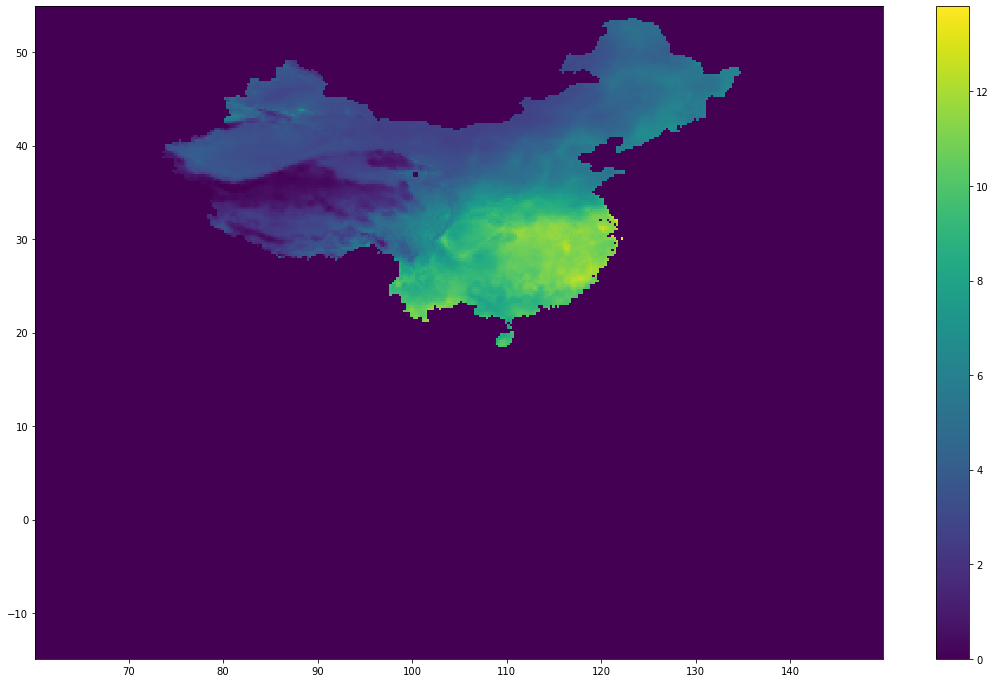

In [29]:
plt.pcolormesh(x, y, YaSum[:,:])
plt.colorbar()
#plt.plot(x[50], y[50], 'rx')

#### Grass model (gridded, era5, aphrodite, ceres)

Loop over years

In [31]:
startyears = np.arange(2014, 2015)
startmonth = 1
startday = 1
endyears = np.arange(2014, 2015)
endmonth = 12
endday = 31

downloaddata = 0
latmax = 54.875 # only used if downloaddata == 1
lonmin = 60.125
latmin = -14.875
lonmax = 149.875

dataloc = "/prj/verdant/matbro/data/driving_china/*.nc"
saveloc = '/prj/verdant/matbro/data/grass_driving_china/netcdf'
outloc  = '/prj/verdant/matbro/outputs/yields'
#elevfile = '/prj/verdant/matbro/data/NextMap_DTM_50m.tif'
CO2file = '/prj/verdant/matbro/data/UKCP18_CO2_RCP85.csv'
simx = '01'
crop = 'grass'
xdimname = 'longitude'
ydimname = 'latitude'
basedatasetname = 'era5'
precipname = 'aphrodite'
radname = 'ceres-syn'
mask = 1

In [ ]:
for year in startyears:
    startmonthstr = '{:02.0f}'.format(startmonth)
    startdaystr = '{:02.0f}'.format(startday)
    endmonthstr = '{:02.0f}'.format(endmonth)
    enddaystr = '{:02.0f}'.format(endday)
    
    if basedatasetname=='ukcp18' or basedatasetname=='ukcp18bc':
        ctype = '360_day'
    else:
        ctype = 'gregorian'

    # extract out a year's worth of obs
    # TODO adapt to handle non-360day calendars
    # can use days_in_month code from PET project
    gyeardates = xr.cftime_range(str(year) + '-' + startmonthstr + '-' + startdaystr,
                                 str(year+1) + '-' + endmonthstr + '-' + enddaystr,
                                 calendar=ctype, freq='D', name='date').values

    print('Running for ' + str(gyeardates[0]) + ' to ' + str(gyeardates[-1]))

    times = np.array([str(t.year)+'{:02.0f}'.format(t.month)+'{:02.0f}'.format(t.day) for t in list(gyeardates)])

    dd = load_driving_data(basedatasetname, times, dataloc, saveloc, simx, crop, 
                           CO2file=CO2file, mask=mask, radname=radname, precipname=precipname, 
                           downloaddata=downloaddata, lonmin=lonmin, lonmax=lonmax, latmin=latmin, latmax=latmax)

    tmean = dd['tmean']
    tmax  = dd['tmax']
    tmin  = dd['tmin']
    prec  = dd['prec']
    tdp   = dd['tdp']
    wind  = dd['wind']
    sfcP  = dd['sfcP']
    solarrad = dd['solarrad']
    x = dd['x']
    y = dd['y']
    t = dd['t']
    cconc = dd['cconc']

    r['source']('Grass_potpredict_MJB.R')
    grassfunc = r['grass_py']
    print('Running grass model')
    datalist = grassfunc(tmean, tmax, tmin, prec, solarrad, tdp, wind,
                         x, y, t, basedatasetname, precipname, radname, cconc, sfcP)

    PET = np.array(datalist.rx2('PET'))
    AET = np.array(datalist.rx2('AET'))
    SMD = np.array(datalist.rx2('SMD'))
    Yp  = np.array(datalist.rx2('Yp'))
    Ya  = np.array(datalist.rx2('Ya'))
    EaEp = np.array(datalist.rx2('EaEp'))
    RUE    = np.array(datalist.rx2('RUE'))
    preRUE = np.array(datalist.rx2('preRUE'))
    Rr  = np.array(datalist.rx2('Rr'))
    Tt  = np.array(datalist.rx2('Tt'))
    Tdp  = np.array(datalist.rx2('Tdp'))
    prec = np.array(datalist.rx2('prec'))
    sfcP = np.array(datalist.rx2('sfcP'))
    #TtX = np.array(datalist.rx2('TtX'))
    x2   = np.array(datalist.rx2('x'))
    e    = np.array(datalist.rx2('e'))
    YaSum = np.array(datalist.rx2('YaSum'))
    print(YaSum[50,50])
    #yields = xr.DataArray(YaSum, coords = [y, x], dims=['y', 'x'])
    #yields = yields.expand_dims({'time': [str(year+1)]})
    #yields.name = 'yield'
    #yields.attrs = {'units': 'tn/hc'}
    #outfile = os.path.join(outloc, 'grass_era5_aphrodite_ceres_' + str(year) + '.nc')
    #yields.to_netcdf(outfile)

Running for 2015-01-01 00:00:00 to 2015-12-31 00:00:00
Producing subsetted driving data nc file(s):
Processing APHRO_MA_025deg_V1101
Masking data to ['China']
Found: China
Adding mask to xarray
Processing maximum_2m_temperature_since_previous_post_processing
Masking data to ['China']
Found: China
Adding mask to xarray
Processing minimum_2m_temperature_since_previous_post_processing
Masking data to ['China']
Found: China
Adding mask to xarray
Processing 2m_dewpoint_temperature


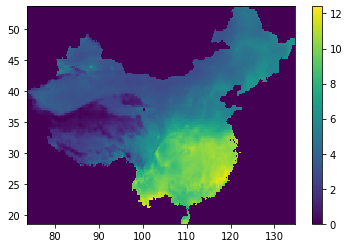

In [108]:
plt.pcolormesh(x, y, YaSum[:,:])
plt.colorbar()

### AWC calculation for China

The dataset provides the volumetric soil water content (theta, I think...) at the wilting point (point at which plants can no longer extract water), field capacity (something like the capacity of the soil after gravity-drain of excess, but before dry-down begins, so approximately the value the soil will reach during a wet season, briefly exceed during heavy rain, and only decrease from slowly) and saturation point (point at which soil can physically hold no more water).

The available water capacity (AWC) is typically calculated using the field capacity, but I found this produced values that were too low, so I used the saturation point instead. Both calculations are shown here.

The 'AWC_China.nc' and 'AWC_China_sat_ch.nc' files that are processed here were calculated from the dataset files using the get_AWC_China.sh script in the data folder.

####  Using $\theta_{fc}$

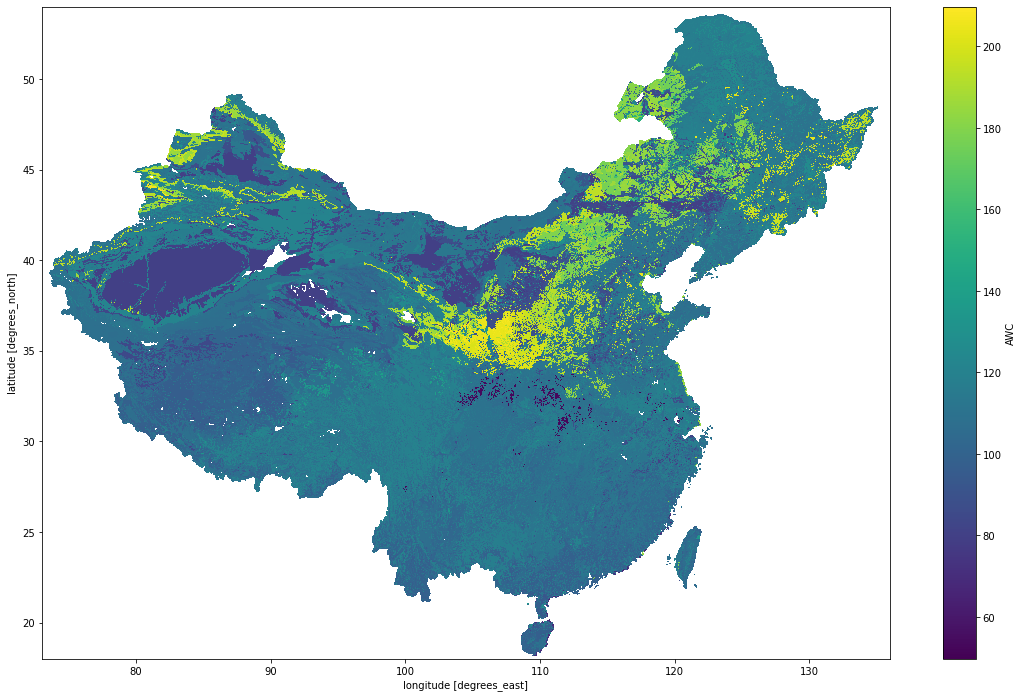

In [3]:
AWCvol = xr.load_dataarray('data/AWC_China.nc')

# Get thickness of layers in file
layerdepths = [0] + list(AWCvol['depth'].values)
layerthickness = np.array(layerdepths[1:]) - np.array(layerdepths[:-1])
layerthicknessmm = layerthickness*10

# Multiply values by thickness of the layers to get water content in mms for each layer
AWCmm = AWCvol.transpose('lat', 'lon', 'depth') * layerthicknessmm
AWCmm.to_netcdf('data/AWC_China_mms.nc')
# Sum over all layers to get total AWC in soil column
AWCtotmm = AWCmm.sum('depth')
AWCtotmm.to_netcdf('data/AWC_China_totalmms.nc')
AWCtotmm = AWCtotmm.where(AWCtotmm > 0)

plt.rcParams['figure.figsize'] = [19, 12]
AWCtotmm.plot()

#### Using $\theta_{sat}$

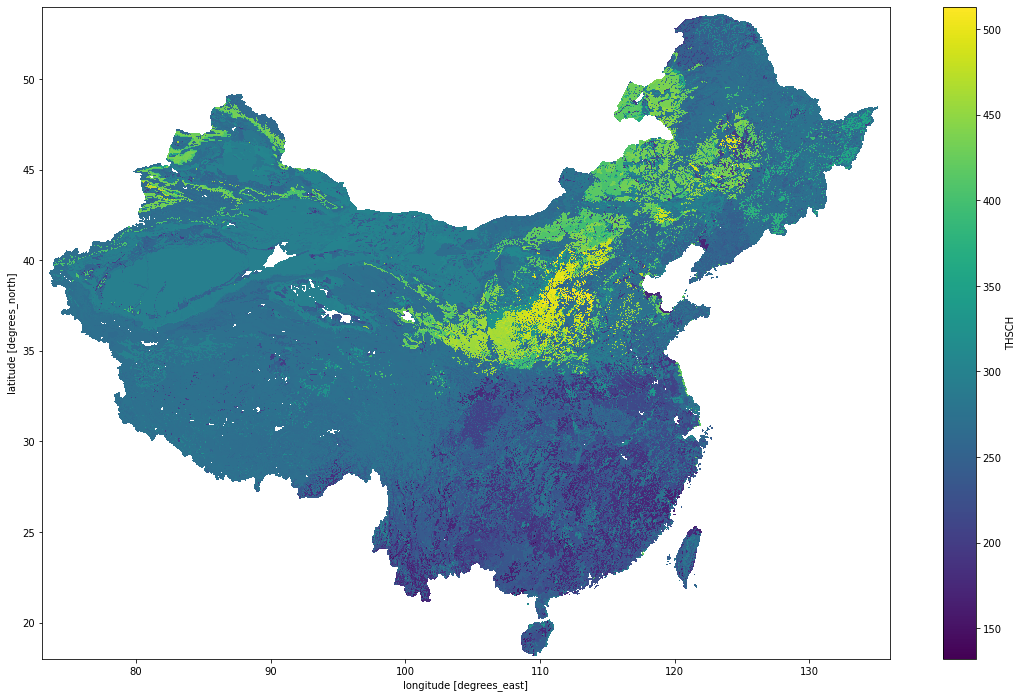

In [21]:
AWCvol1 = xr.load_dataarray('data/AWC_China_sat_ch.nc')

layerdepths = [0] + list(AWCvol1['depth'].values)
layerthickness = np.array(layerdepths[1:]) - np.array(layerdepths[:-1])
layerthicknessmm = layerthickness*10

AWCmm1 = AWCvol1.transpose('lat', 'lon', 'depth') * layerthicknessmm
AWCmm1.to_netcdf('data/AWC_China_sat_ch_mms.nc')
AWCtotmm1 = AWCmm1.sum('depth')
AWCtotmm1 = AWCtotmm1.where(AWCtotmm1 > 0)
AWCtotmm1.to_netcdf('data/AWC_China_sat_ch_totalmms.nc')

plt.rcParams['figure.figsize'] = [19, 12]
AWCtotmm1.plot()
plt.savefig('plots/AWCChina_sat_ch.png', dpi=600)

### Wheat model runs

#### Wheat (grid, era5)

In [36]:
startyear = 2014
startmonth = 10
startday = 1
endyear = 2015
endmonth = 9
endday = 30

downloaddata = 0
maskdata = 1
countries = ['China'] # countries to mask data to
latmax = 54.875 # only used if downloaddata == 1
lonmin = 60.125
latmin = -14.875
lonmax = 149.875

# science switches
waterlog = 1 # enable/disable waterlogging effect
noflower = 1 # enable/disable flower failure effect
# irrigation is disabled by default

dataloc = "/prj/verdant/matbro/data/driving_china/*.nc"
saveloc = '/prj/verdant/matbro/data/wheat_driving_china'
AWCrast = "/prj/verdant/matbro/data/AWC_China_sat_ch_totalmms.nc"
CO2file = '/prj/verdant/matbro/data/UKCP18_CO2_RCP85.csv'
simx = '01'
crop='wheat'
basedatasetname = 'era5'

In [64]:
startmonthstr = '{:02.0f}'.format(startmonth)
startdaystr = '{:02.0f}'.format(startday)
endmonthstr = '{:02.0f}'.format(endmonth)
enddaystr = '{:02.0f}'.format(endday)

# extract out a year's worth of obs
# TODO adapt to handle non-360day calendars
# can use days_in_month code from PET project
if basedatasetname=='ukcp18' or basedatasetname=='ukcp18bc':
    ctype = '360_day'
else:
    ctype = 'gregorian'
gyeardates = xr.cftime_range(str(startyear) + '-' + startmonthstr + '-' + startdaystr,
                             str(endyear) + '-' + endmonthstr + '-' + enddaystr,
                             calendar=ctype, freq='D', name='date').values

print('Running for ' + str(gyeardates[0]) + ' to ' + str(gyeardates[-1]))

times = np.array([str(t.year)+'{:02.0f}'.format(t.month)+'{:02.0f}'.format(t.day) for t in list(gyeardates)])

r['source']('Lynch_potpredict_v2_MJB.R')
dd = load_driving_data(basedatasetname, times,
                       dataloc, saveloc, simx, crop, AWCrast, CO2file, 
                       lonmin, lonmax, latmin, latmax, downloaddata, maskdata, countries=countries)

tmean = dd['tmean']
tmax  = dd['tmax']
tmin  = dd['tmin']
prec  = dd['prec']
solarrad = dd['solarrad']
AWC = dd['AWC']
x = dd['x']
y = dd['y']
t = dd['t']
cconc = dd['cconc']
lons,lats = np.meshgrid(x,y)

GAIfunc = r['GAI']
print('Running model, calculating GAI')
datalist = GAIfunc(tmean, tmax, tmin, prec, solarrad, x, y, t, lats, basedatasetname)
GAI = np.array(datalist.rx2('GAI'))
tmean       = np.array(datalist.rx2('tmean'))
prec        = np.array(datalist.rx2('prec'))
solarrad    = np.array(datalist.rx2('solarrad'))
Jarray      = np.array(datalist.rx2('Jarray'))
Cday        = np.array(datalist.rx2('Cday'))
CDD         = np.array(datalist.rx2('CDD'))
TT          = np.array(datalist.rx2('TT'))
VD          = np.array(datalist.rx2('VD'))
DDorig      = np.array(datalist.rx2('DDorig'))
DL14        = np.array(datalist.rx2('DL14'))
DL          = np.array(datalist.rx2('DL'))
GSS_r       = datalist.rx2('GSS')
GSS         = np.array(datalist.rx2('GSS')) # As it's a string array it comes out as a flattened array               
GSS         = GSS.reshape((GSS_r.dim[2], GSS_r.dim[1], GSS_r.dim[0]))
GSS         = GSS.transpose(2,1,0) # therefore we need to manually reshape it                                         
HarvestJday = datalist.rx2('HarvestJday')

#r['source']('Lynch_potpredict_v2_MJB.R')
#yieldfunc = r['wheat_yield']
#print('Calculating yield')
#datalist2 = yieldfunc(GAI, tmean, prec, solarrad, AWC, Jarray, Cday, GSS, HarvestJday, 
#                      CDD, TT, x, y, cconc, waterlog, noflower)
#yields = np.array(datalist2.rx2('finalyield'))
#print(yields[50,50])

Running for 2014-10-01 00:00:00 to 2015-09-30 00:00:00
Producing subsetted driving data nc file(s):
Driving data file already exists, skipping generation
Reading in driving data from file
Processing data into format ready for model
Reading in prec
Reading in tmax
Reading in tmin
Reading in solarrad
Reading in tmean
Reading in AWC
Interpolating AWC onto common grid
Masking AWC to ['China']
Found: China
Adding mask to xarray
Done
Passing data to model
Running model, calculating GAI
[1] "Using era5 data, units:"
[1] "Temperature: Converting from Kelvin to Celsius"
[1] "Precip: Converting from m to mm"
[1] "Solar rad: converting from J/m^2/day to W/m^2"
[1] 280 360


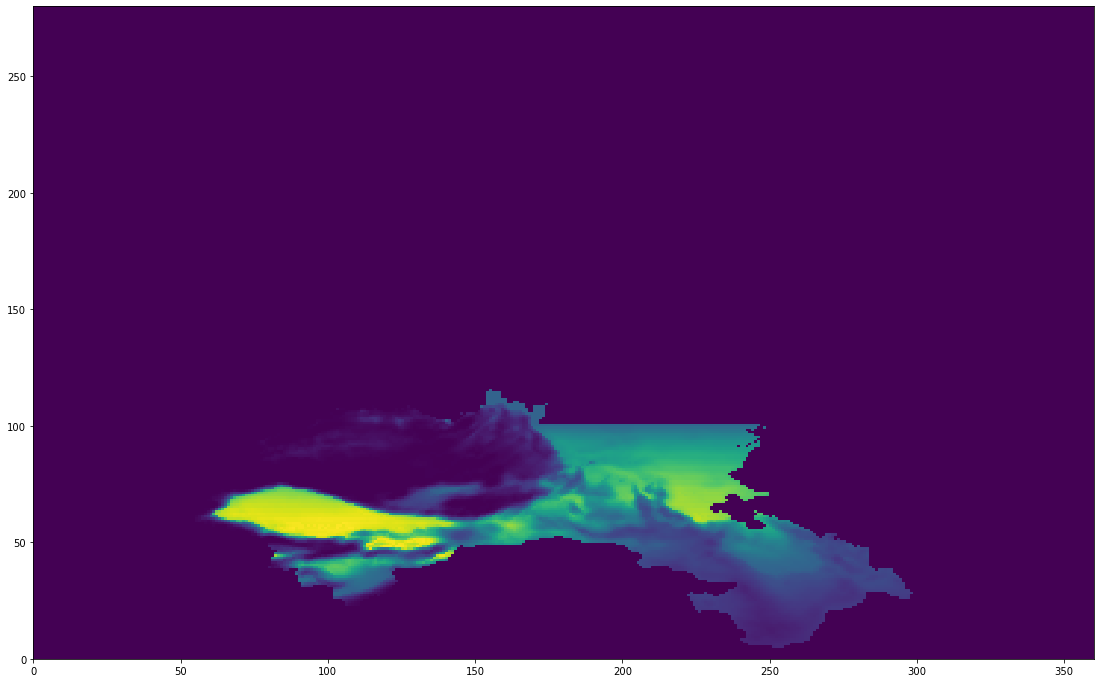

In [38]:
plt.pcolormesh(GAI[:,:,250])

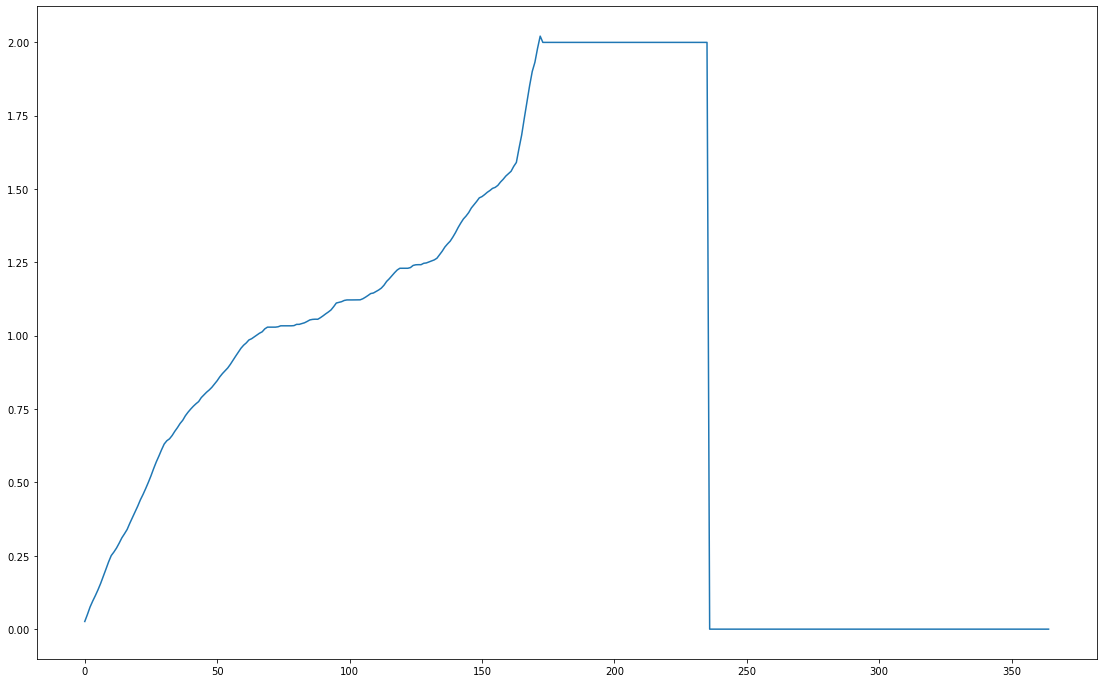

In [39]:
plt.plot(GAI[110,180,:])

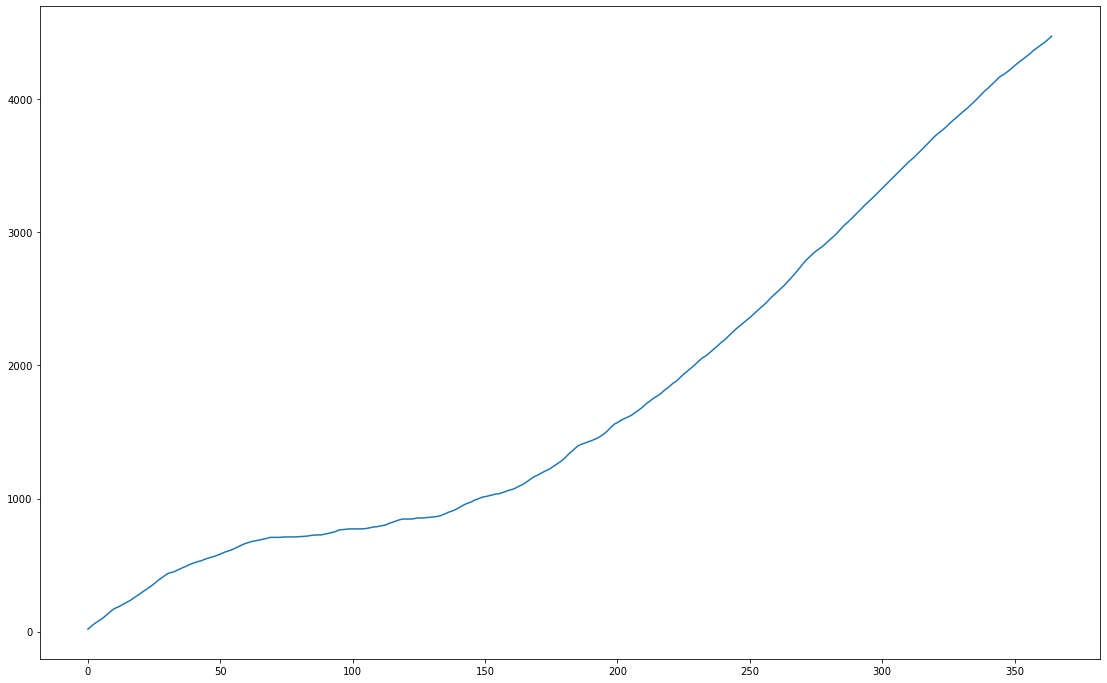

In [50]:
plt.plot(DDorig[110,180,:].cumsum())

In [52]:
DDorig[110,180,:].cumsum()[173]

1209.1578194620806

In [46]:
VD[110,180,:172].sum()

136.02461231400824

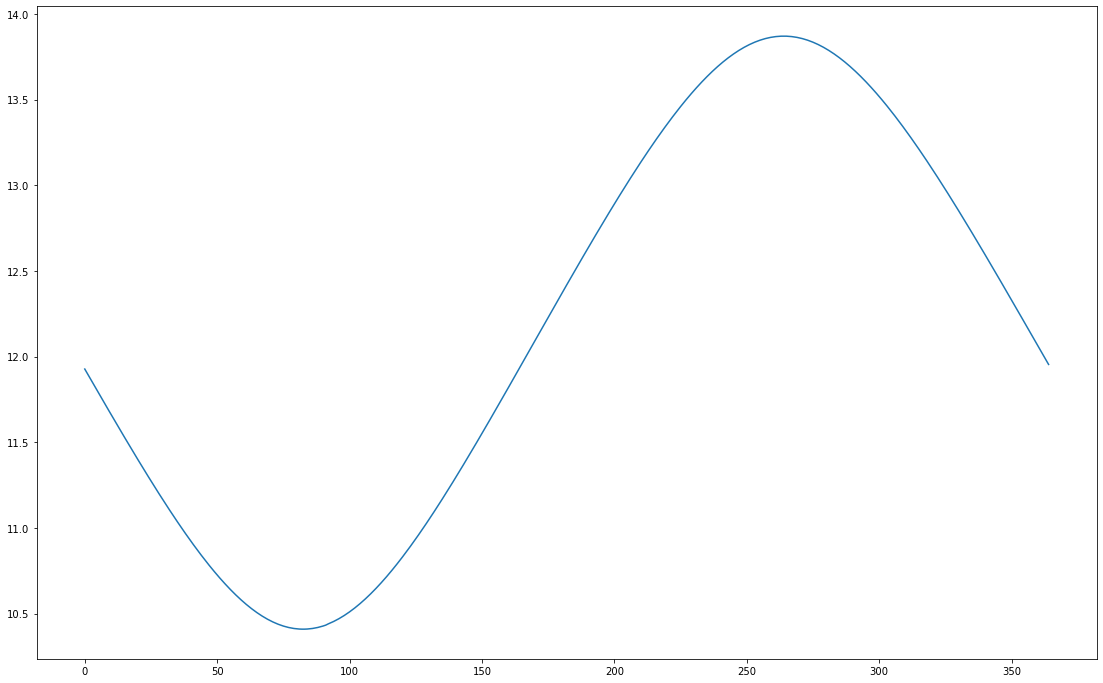

In [68]:
plt.plot(DL[110,180,:])

In [69]:
lats

array([[ 54.875,  54.875,  54.875, ...,  54.875,  54.875,  54.875],
       [ 54.625,  54.625,  54.625, ...,  54.625,  54.625,  54.625],
       [ 54.375,  54.375,  54.375, ...,  54.375,  54.375,  54.375],
       ...,
       [-14.375, -14.375, -14.375, ..., -14.375, -14.375, -14.375],
       [-14.625, -14.625, -14.625, ..., -14.625, -14.625, -14.625],
       [-14.875, -14.875, -14.875, ..., -14.875, -14.875, -14.875]],
      dtype=float32)

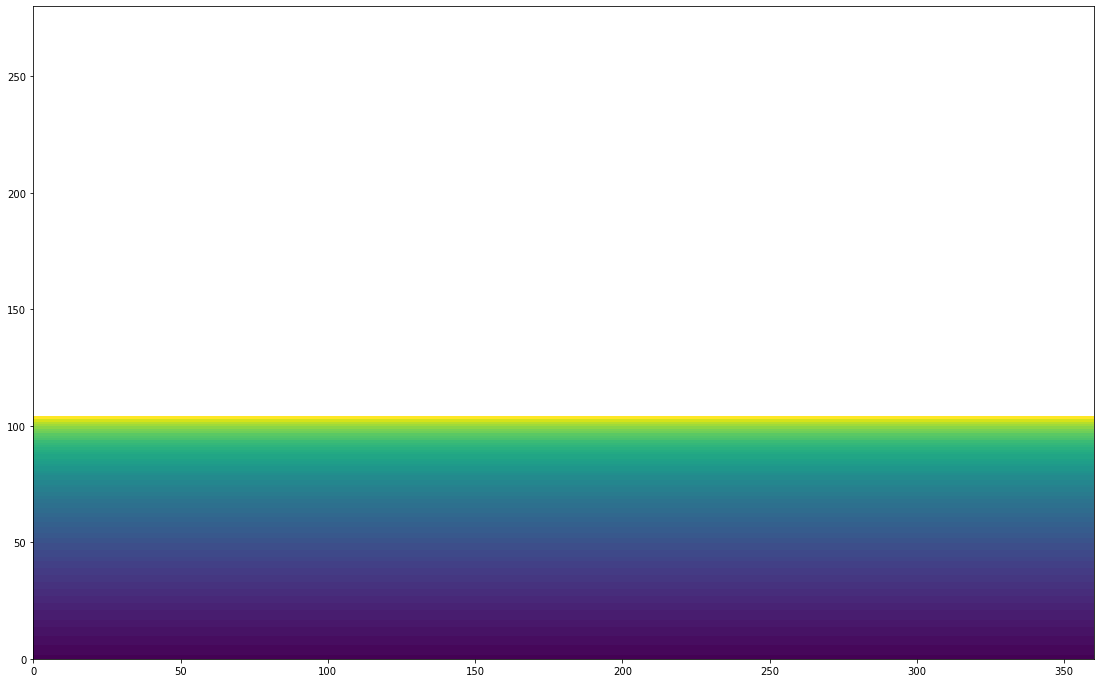

In [61]:
plt.pcolormesh(DL14)

In [48]:
GSS[110,180,173]

'GS31-GS61'

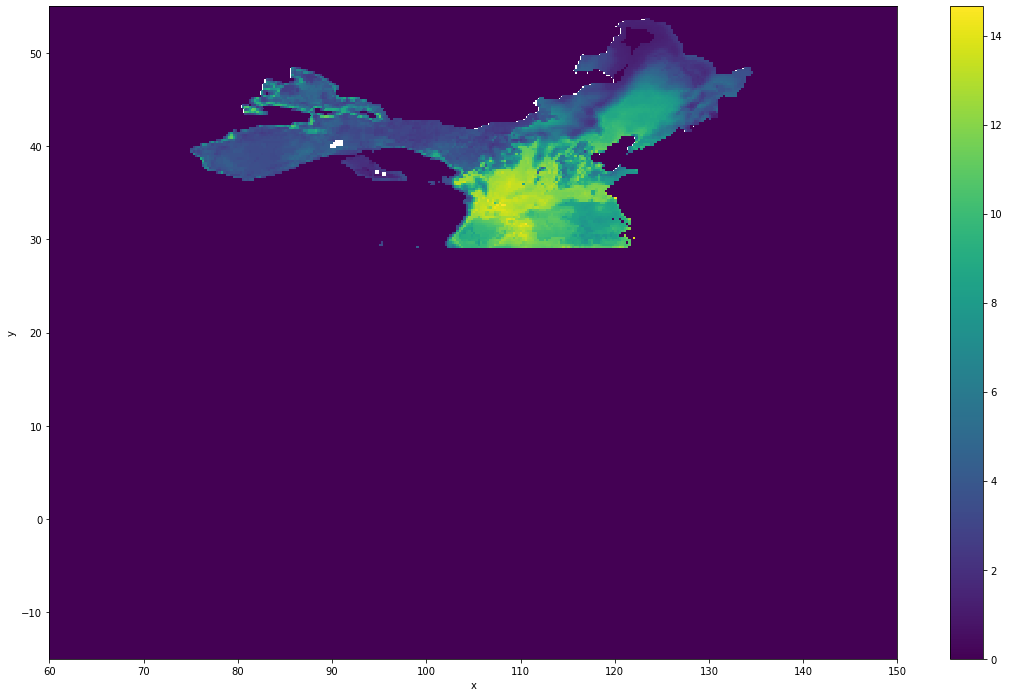

In [7]:
yields = xr.DataArray(yields, coords=[y, x], dims=['y', 'x'])
yields.plot()

#### Wheat model (grid, era5+aphrodite)

In [11]:
startyear = 2014
startmonth = 10
startday = 1
endyear = 2015
endmonth = 9
endday = 30

# science switches (1=enabled, 0=disabled)
waterlog = 1 # enable/disable waterlogging effect
noflower = 1 # enable/disable flower failure effect
# irrigation is disabled by default

downloaddata = 0
maskdata = 1
countries = ['China'] # countries to mask data to
latmax = 54.875 # only used if downloaddata == 1
lonmin = 60.125
latmin = -14.875
lonmax = 149.875

dataloc = "/prj/verdant/matbro/data/driving_china/*.nc"
saveloc = '/prj/verdant/matbro/data/wheat_driving_china'
outloc  = '/prj/verdant/matbro/data/outputs/yields'
AWCrast = "/prj/verdant/matbro/data/AWC_China_totalmms.nc"
CO2file = '/prj/verdant/matbro/data/UKCP18_CO2_RCP85.csv'
simx = '01'
crop='wheat'
basedatasetname = 'era5'
precipname = 'aphrodite'

In [12]:
startmonthstr = '{:02.0f}'.format(startmonth)
startdaystr = '{:02.0f}'.format(startday)
endmonthstr = '{:02.0f}'.format(endmonth)
enddaystr = '{:02.0f}'.format(endday)

# extract out a year's worth of obs
# TODO adapt to handle non-360day calendars
# can use days_in_month code from PET project
if basedatasetname=='ukcp18' or basedatasetname=='ukcp18bc':
    ctype = '360_day'
else:
    ctype = 'gregorian'
gyeardates = xr.cftime_range(str(startyear) + '-' + startmonthstr + '-' + startdaystr,
                             str(endyear) + '-' + endmonthstr + '-' + enddaystr,
                             calendar=ctype, freq='D', name='date').values

print('Running for ' + str(gyeardates[0]) + ' to ' + str(gyeardates[-1]))

times = np.array([str(t.year)+'{:02.0f}'.format(t.month)+'{:02.0f}'.format(t.day) for t in list(gyeardates)])


r['source']('Lynch_potpredict_v2_MJB.R')
dd = load_driving_data(basedatasetname, times,
                       dataloc, saveloc, simx, crop, AWCrast, CO2file, 
                       lonmin, lonmax, latmin, latmax, downloaddata, maskdata, 
                       precipname=precipname)

tmean = dd['tmean']
tmax  = dd['tmax']
tmin  = dd['tmin']
prec  = dd['prec']
solarrad = dd['solarrad']
AWC = dd['AWC']
x = dd['x']
y = dd['y']
t = dd['t']
cconc = dd['cconc']
lons,lats = np.meshgrid(x,y)

GAIfunc = r['GAI']
print('Running model, calculating GAI')
datalist = GAIfunc(tmean, tmax, tmin, prec, solarrad, x, y, t, lats, basedatasetname, precipname)
GAI = np.array(datalist.rx2('GAI'))
tmean       = np.array(datalist.rx2('tmean'))
prec        = np.array(datalist.rx2('prec'))
solarrad    = np.array(datalist.rx2('solarrad'))
Jarray      = np.array(datalist.rx2('Jarray'))
Cday        = np.array(datalist.rx2('Cday'))
CDD         = np.array(datalist.rx2('CDD'))
TT          = np.array(datalist.rx2('TT'))
GSS_r       = datalist.rx2('GSS')
GSS         = np.array(datalist.rx2('GSS')) # As it's a string array it comes out as a flattened array               
GSS         = GSS.reshape((GSS_r.dim[2], GSS_r.dim[1], GSS_r.dim[0]))
GSS         = GSS.transpose(2,1,0) # therefore we need to manually reshape it                                         
HarvestJday = datalist.rx2('HarvestJday')

r['source']('Lynch_potpredict_v2_MJB.R')
yieldfunc = r['wheat_yield']
print('Calculating yield')
yields = yieldfunc(GAI, tmean, prec, solarrad, AWC, Jarray, Cday, GSS, HarvestJday, CDD, TT, 
                      x, y, cconc, waterlim, waterlog, noflower)

datalist2 = yieldfunc(GAI, tmean, prec, solarrad, AWC, Jarray, Cday, GSS, HarvestJday,
                      CDD, TT, x, y, cconc, waterlog, noflower)
yields = np.array(datalist2.rx2('finalyield'))
#outfile = os.path.join(outloc + 'wheat_era5_aphrodite_' + str(endyear) + '.nc')
#yields.to_netcdf(outfile)

Running for 2014-10-01 00:00:00 to 2015-09-30 00:00:00
Producing subsetted driving data nc file(s):
Processing APHRO_MA_025deg_V1101
Masking data to ['China']
Found: China
Adding mask to xarray
Processing maximum_2m_temperature_since_previous_post_processing
Masking data to ['China']
Found: China
Adding mask to xarray
Processing minimum_2m_temperature_since_previous_post_processing
Masking data to ['China']
Found: China
Adding mask to xarray
Processing surface_net_solar_radiation
Masking data to ['China']
Found: China
Adding mask to xarray
Processing 2m_temperature
Masking data to ['China']
Found: China
Adding mask to xarray
Merging data
Processing and saving to disk
[########################################] | 100% Completed |  1.2s
[########################################] | 100% Completed | 31.0s
Reading in driving data from file
Processing data into format ready for model
Reading in prec
Reading in tmax
Reading in tmin
Reading in solarrad
Reading in tmean
Reading in AWC
Interpolat

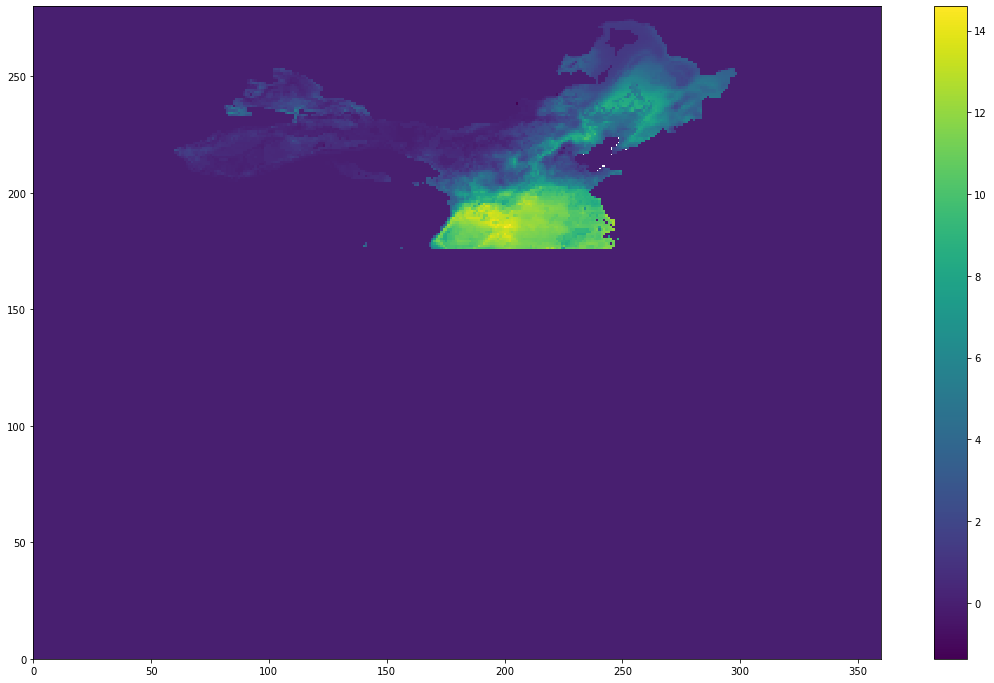

In [13]:
plt.pcolormesh(np.array(yields)[::-1,:])
plt.colorbar()

#### Wheat model (grid, era5, aphrodite, ceres-syn)

In [15]:
startyear = 2013
startmonth = 10
startday = 1
endyear = 2014
endmonth = 9
endday = 30
xdimname = 'longitude'
ydimname = 'latitude'

# science switches
waterlog = 1 # enable/disable waterlogging effect
noflower = 1 # enable/disable flower failure effect
# irrigation is disabled by default

downloaddata = 0
maskdata = 1
countries = ['China'] # countries to mask data to
latmax = 54.875 # only used if downloaddata == 1
lonmin = 60.125
latmin = -14.875
lonmax = 149.875

dataloc = "/prj/verdant/matbro/data/driving_china/*.nc"
saveloc = '/prj/verdant/matbro/data/wheat_driving_china'
AWCrast = "/prj/verdant/matbro/data/AWC_China_sat_ch_totalmms.nc"
CO2file = '/prj/verdant/matbro/data/UKCP18_CO2_RCP85.csv'
simx = '01'
crop='wheat'
basedatasetname = 'era5'
precipname = 'aphrodite'
radname = 'ceres-syn'

In [16]:
startmonthstr = '{:02.0f}'.format(startmonth)
startdaystr = '{:02.0f}'.format(startday)
endmonthstr = '{:02.0f}'.format(endmonth)
enddaystr = '{:02.0f}'.format(endday)

# extract out a year's worth of obs
# TODO adapt to handle non-360day calendars
# can use days_in_month code from PET project
if basedatasetname=='ukcp18' or basedatasetname=='ukcp18bc':
    ctype = '360_day'
else:
    ctype = 'gregorian'
gyeardates = xr.cftime_range(str(startyear) + '-' + startmonthstr + '-' + startdaystr,
                             str(endyear) + '-' + endmonthstr + '-' + enddaystr,
                             calendar=ctype, freq='D', name='date').values

print('Running for ' + str(gyeardates[0]) + ' to ' + str(gyeardates[-1]))

times = np.array([str(t.year)+'{:02.0f}'.format(t.month)+'{:02.0f}'.format(t.day) for t in list(gyeardates)])


r['source']('Lynch_potpredict_v2_MJB.R')
dd = load_driving_data(basedatasetname, times,
                       dataloc, saveloc, simx, crop, AWCrast, CO2file, 
                       lonmin, lonmax, latmin, latmax, downloaddata, maskdata, 
                       precipname=precipname, radname=radname)

tmean = dd['tmean']
tmax  = dd['tmax']
tmin  = dd['tmin']
prec  = dd['prec']
solarrad = dd['solarrad']
AWC = dd['AWC']
x = dd['x']
y = dd['y']
t = dd['t']
cconc = dd['cconc']
lons,lats = np.meshgrid(x,y)

GAIfunc = r['GAI']
print('Running model, calculating GAI')
datalist = GAIfunc(tmean, tmax, tmin, prec, solarrad, x, y, t, lats, basedatasetname, precipname, radname)
GAI = np.array(datalist.rx2('GAI'))
tmean       = np.array(datalist.rx2('tmean'))
prec        = np.array(datalist.rx2('prec'))
solarrad    = np.array(datalist.rx2('solarrad'))
Jarray      = np.array(datalist.rx2('Jarray'))
Cday        = np.array(datalist.rx2('Cday'))
CDD         = np.array(datalist.rx2('CDD'))
TT          = np.array(datalist.rx2('TT'))
GSS_r       = datalist.rx2('GSS')
GSS         = np.array(datalist.rx2('GSS')) # As it's a string array it comes out as a flattened array               
GSS         = GSS.reshape((GSS_r.dim[2], GSS_r.dim[1], GSS_r.dim[0]))
GSS         = GSS.transpose(2,1,0) # therefore we need to manually reshape it                                         
HarvestJday = datalist.rx2('HarvestJday')

r['source']('Lynch_potpredict_v2_MJB.R')
yieldfunc = r['wheat_yield']
print('Calculating yield')
datalist2 = yieldfunc(GAI, tmean, prec, solarrad, AWC, Jarray, Cday, GSS, HarvestJday, 
                      CDD, TT, x, y, cconc, waterlog, noflower)
yields = np.array(datalist2.rx2('finalyield'))

Running for 2013-10-01 00:00:00 to 2014-09-30 00:00:00
Producing subsetted driving data nc file(s):
Processing APHRO_MA_025deg_V1101
Masking data to ['China']
Found: China
Adding mask to xarray
Processing maximum_2m_temperature_since_previous_post_processing
Masking data to ['China']
Found: China
Adding mask to xarray
Processing minimum_2m_temperature_since_previous_post_processing
Masking data to ['China']
Found: China
Adding mask to xarray
Processing CERES_SYN1deg-Day
Masking data to ['China']
Found: China
Adding mask to xarray
Processing 2m_temperature
Masking data to ['China']
Found: China
Adding mask to xarray
Merging data
Processing and saving to disk
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed | 19.7s
Reading in driving data from file
Processing data into format ready for model
Reading in prec
Reading in tmax
Reading in tmin
Reading in solarrad
Reading in tmean
Reading in AWC
Interpolating AWC on

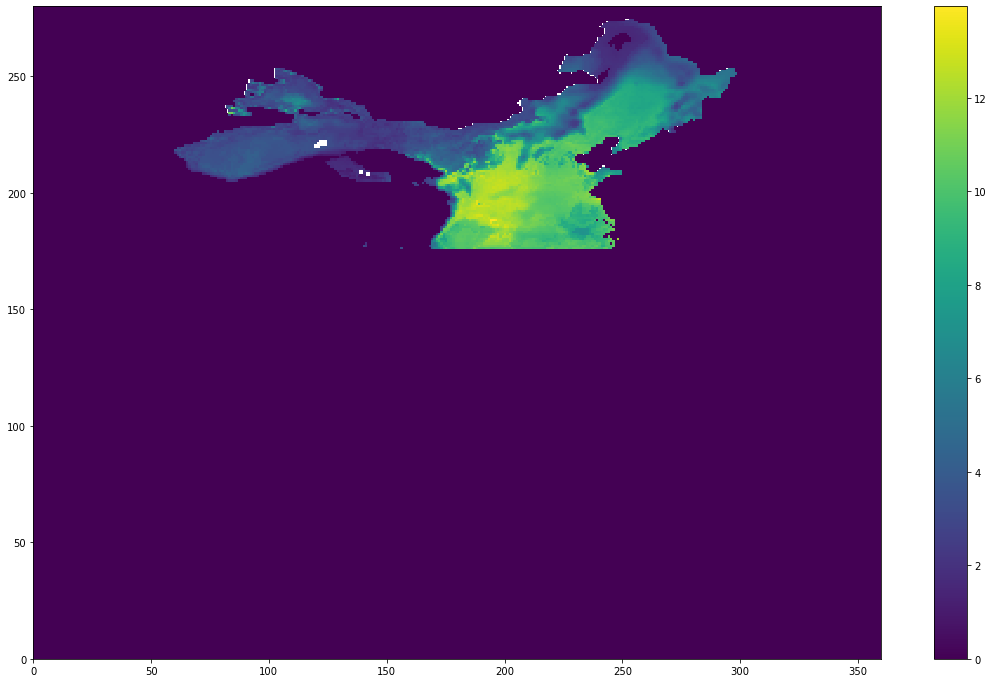

In [17]:
plt.pcolormesh(np.array(yields)[::-1,:])
plt.colorbar()

In [67]:
yields = xr.DataArray(yields, coords = [y, x], dims=['y', 'x'])
yields.to_netcdf('wheat_WLyield_era5_aphrodite_ceres_waterlogging_satAWC.nc')

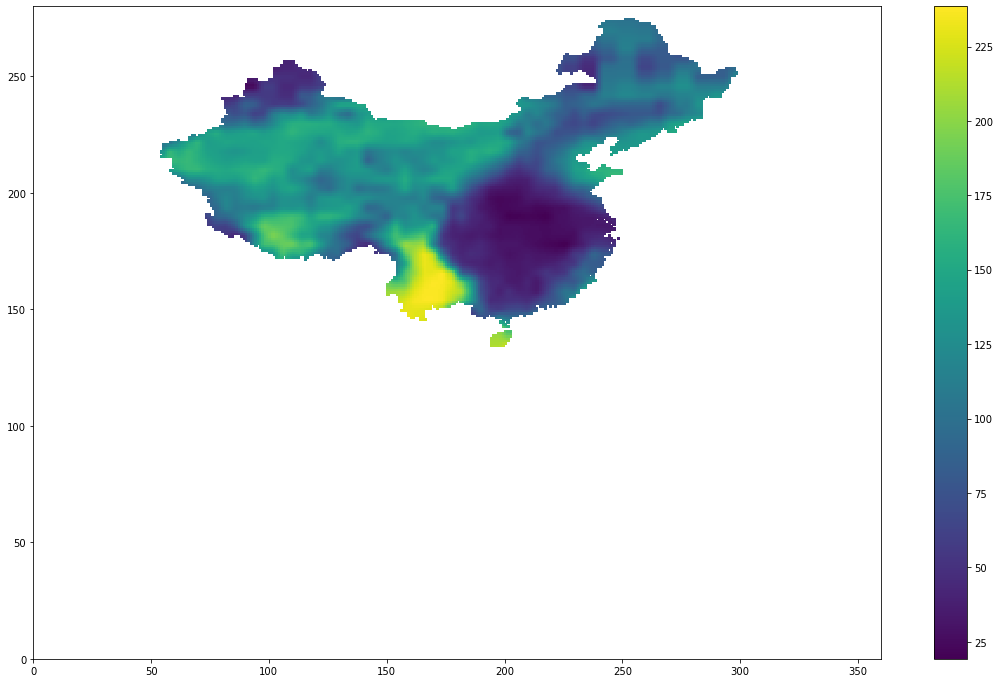

In [18]:
plt.pcolormesh(np.array(solarrad)[::-1,:,150])
plt.colorbar()

#### Wheat model (gridded, era5, ahprodite, cropmask, irrigation)

Loop over years

In [2]:
startyears = np.arange(2013, 2014)
startmonth = 10
startday = 1
endyears = np.arange(2014, 2015)
endmonth = 9
endday = 30

# science switches
waterlog = 1 # enable/disable waterlogging effect
noflower = 1 # enable/disable flower failure effect
irrigation = 1 # enable/disable irrigation effect
irrfile = 'data/wheat_irrigated_proportion.nc'

maskdata = 1
countries = ['China'] # countries to mask data to
cropmask = 1 # mask out non-crop regions
cropfile = 'data/wheatmapchina.nc'

downloaddata = 0
latmax = 54.875 # only used if downloaddata == 1
lonmin = 60.125
latmin = -14.875
lonmax = 149.875

dataloc = "/prj/verdant/matbro/data/driving_china/*.nc"
saveloc = '/prj/verdant/matbro/data/wheat_driving_china'
outloc  = '/prj/verdant/matbro/outputs/yields'
AWCrast = "/prj/verdant/matbro/data/AWC_China_sat_ch_totalmms.nc"
CO2file = '/prj/verdant/matbro/data/UKCP18_CO2_RCP85.csv'
simx = '01'
crop='wheat'
basedatasetname = 'era5'
precipname = 'aphrodite'
radname = 'None'

In [4]:
r['source']('Lynch_potpredict_v2_MJB.R')
for year in startyears:
    
    startmonthstr = '{:02.0f}'.format(startmonth)
    startdaystr = '{:02.0f}'.format(startday)
    endmonthstr = '{:02.0f}'.format(endmonth)
    enddaystr = '{:02.0f}'.format(endday)

    # extract out a year's worth of obs
    # TODO adapt to handle non-360day calendars
    # can use days_in_month code from PET project
    if basedatasetname=='ukcp18' or basedatasetname=='ukcp18bc':
        ctype = '360_day'
    else:
        ctype = 'gregorian'
    gyeardates = xr.cftime_range(str(year) + '-' + startmonthstr + '-' + startdaystr,
                                 str(year+1) + '-' + endmonthstr + '-' + enddaystr,
                                 calendar=ctype, freq='D', name='date').values

    print('Running for ' + str(gyeardates[0]) + ' to ' + str(gyeardates[-1]))

    times = np.array([str(t.year)+'{:02.0f}'.format(t.month)+'{:02.0f}'.format(t.day) for t in list(gyeardates)])


    dd = load_driving_data(basedatasetname, times,
                           dataloc, saveloc, simx, crop, AWCrast, CO2file, 
                           lonmin, lonmax, latmin, latmax, downloaddata, maskdata, countries=countries, 
                           cropmask=cropmask, cmfile=cropfile, irrmask=irrigation, irrfile=irrfile,
                           precipname=precipname, radname=radname)

    tmean = dd['tmean']
    tmax  = dd['tmax']
    tmin  = dd['tmin']
    prec  = dd['prec']
    solarrad = dd['solarrad']
    AWC = dd['AWC']
    if irrigation == 1:
        irrdata = dd['irrprop']
    x = dd['x']
    y = dd['y']
    t = dd['t']
    cconc = dd['cconc']
    lons,lats = np.meshgrid(x,y)

    GAIfunc = r['GAI']
    print('Running model, calculating GAI')
    datalist = GAIfunc(tmean, tmax, tmin, prec, solarrad, x, y, t, lats, basedatasetname, precipname, radname)
    GAI = np.array(datalist.rx2('GAI'))
    tmean       = np.array(datalist.rx2('tmean'))
    prec        = np.array(datalist.rx2('prec'))
    solarrad    = np.array(datalist.rx2('solarrad'))
    Jarray      = np.array(datalist.rx2('Jarray'))
    Cday        = np.array(datalist.rx2('Cday'))
    CDD         = np.array(datalist.rx2('CDD'))
    TT          = np.array(datalist.rx2('TT'))
    GSS_r       = datalist.rx2('GSS')
    GSS         = np.array(datalist.rx2('GSS')) # As it's a string array it comes out as a flattened array               
    GSS         = GSS.reshape((GSS_r.dim[2], GSS_r.dim[1], GSS_r.dim[0]))
    GSS         = GSS.transpose(2,1,0) # therefore we need to manually reshape it                                         
    HarvestJday = datalist.rx2('HarvestJday')

    r['source']('Lynch_potpredict_v2_MJB.R')
    yieldfunc = r['wheat_yield']
    print('Calculating yield')
    datalist2 = yieldfunc(GAI, tmean, prec, solarrad, AWC, Jarray, Cday, GSS, HarvestJday, CDD, TT, 
                          x, y, cconc, waterlog, noflower, irrigation, irrdata)
    yields = np.array(datalist2.rx2('finalyield'))
    #yields = xr.DataArray(yields, coords = [y, x], dims=['y', 'x'])
    #yields = yields.expand_dims({'time': [str(year+1)]})
    #yields.name = 'yield'
    #yields.attrs = {'units': 'tn/hc'}
    #outfile = os.path.join(outloc, 'wheat_era5_aphrodite_ceres_irr_' + str(year+1) + '.nc')
    #yields.to_netcdf(outfile)

Running for 2013-10-01 00:00:00 to 2014-09-30 00:00:00
Producing subsetted driving data nc file(s):
Driving data file already exists, skipping generation
Reading in driving data from file
Processing data into format ready for model
Reading in prec
Reading in tmax
Reading in tmin
Reading in solarrad
Reading in tmean
Reading in irrmask
Reading in AWC
Interpolating AWC onto common grid
Masking AWC to ['China']
Found: China
Adding mask to xarray
Done
Passing data to model
Running model, calculating GAI
[1] "Using era5 data, units:"
[1] "Temperature: Converting from Kelvin to Celsius"
[1] "Using aphrodite for precip, units mm"
[1] "Solar rad: converting from J/m^2/day to W/m^2"
Calculating yield
[1] 280 360 365
[1] 280 360 365
[1] 280 360 365
[1] 280 360 365


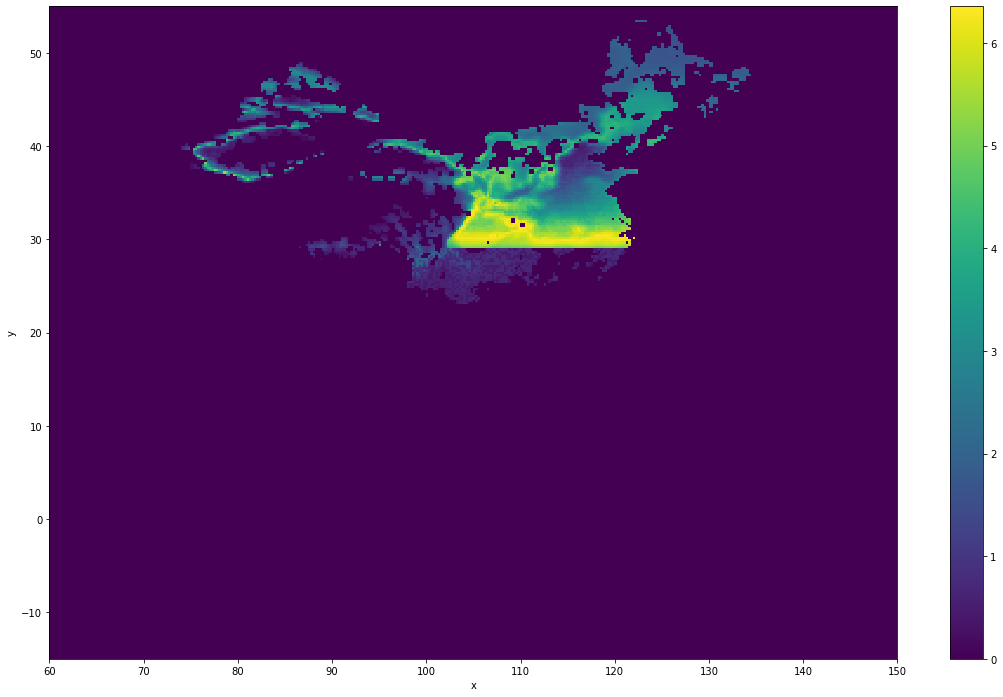

In [54]:
testGAI = xr.DataArray(GAI[:,:,-80], coords = [y, x], dims=['y', 'x'])
testGAI.plot()
#lt.pcolormesh(GAI[::-1,:,-80])

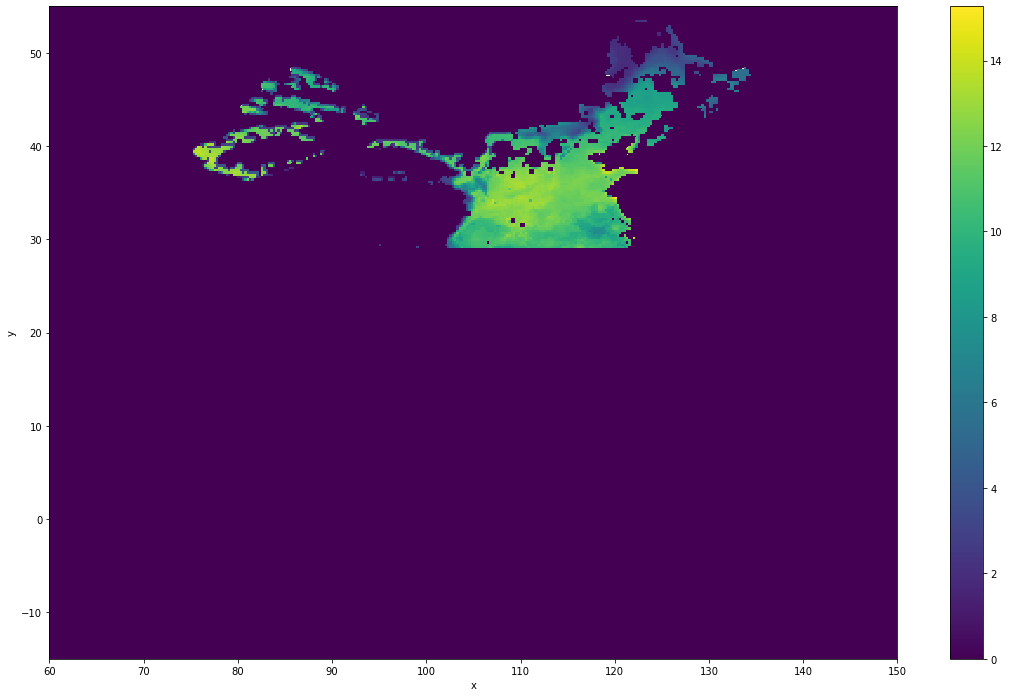

In [55]:
yields = xr.DataArray(yields, coords = [y, x], dims=['y', 'x'])
yields.plot()

In [31]:
yields.to_netcdf('wheat_yield_era5_aphrodite_ceres_waterlogging_satAWC_cropmap_irr.nc')

In [56]:
irrdata = xr.DataArray(irrdata, coords = [y, x], dims=['y', 'x'])

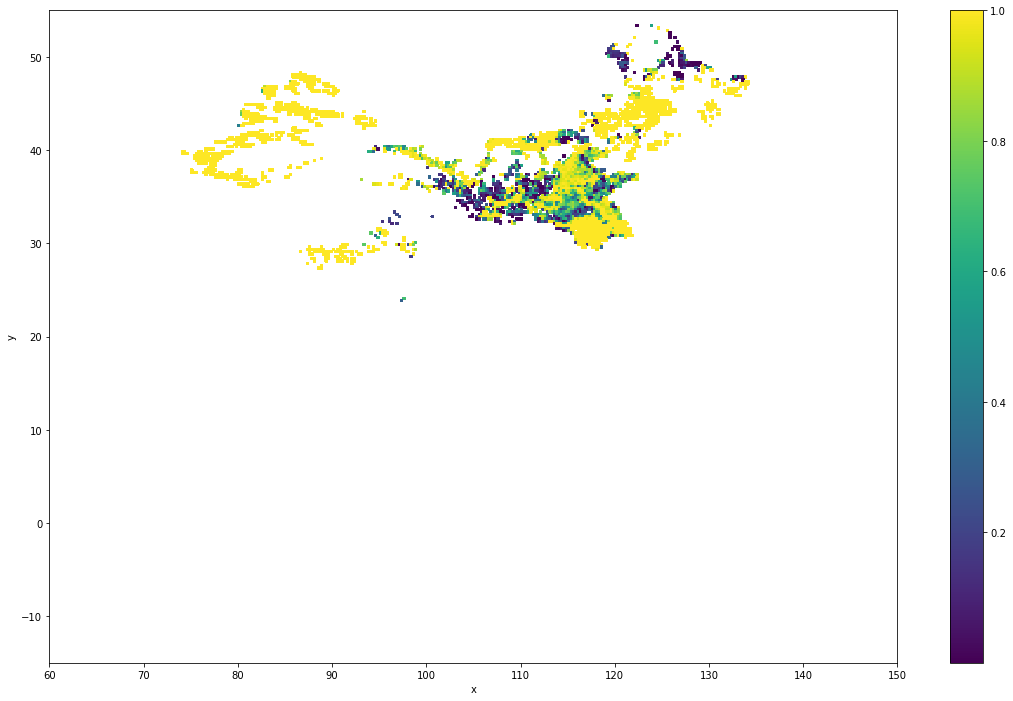

In [57]:
irrdata.plot()

#### Wheat model (gridded, era5, aphrodite, cropmask) with outputs saved to netcdf and climatology calculated

In [1]:
# years to run, and the start and end dates of each year
startyears = np.arange(1980, 2014)
startmonth = 10
startday = 1
endyears = np.arange(1981, 2015)
endmonth = 9
endday = 30

# science switches
waterlog = 1 # enable/disable waterlogging effect
noflower = 1 # enable/disable flower failure effect
irrigation = 0 # enable/disable irrigation effect
# file containing irrigated proportion of land:
irrfile = 'data/wheat_irrigated_proportion.nc'

maskdata = 1
countries = ['China'] # countries to mask data to
cropmask = 1 # mask out non-crop regions
# file containing cropmask:
cropfile = 'data/wheatmapchina.nc'

# don't think auto-downloading of ERA5 data works anymore,
# but it shouldn't matter as the data is already downloaded
downloaddata = 0
latmax = 54.875 # only used if downloaddata == 1
lonmin = 60.125
latmin = -14.875
lonmax = 149.875

# location of driving data netcdf files (note the *.nc on the end):
dataloc = "/prj/verdant/matbro/data/driving_china/*.nc"
# location to save the formatted driving data:
saveloc = '/prj/verdant/matbro/data/wheat_driving_china'
# location of outputs:
outloc  = '/prj/verdant/ssf/crop_model_output/yields'
# Path of the AWC file:
AWCrast = "/prj/verdant/matbro/data/AWC_China_sat_ch_totalmms.nc"
# Path of the CO2 concentration file, set to 'None' to turn off CO2 effect
CO2file = '/prj/verdant/matbro/data/UKCP18_CO2_RCP85.csv'
# Legacy from UKCP18 data, probably could just remove it...
simx = '01'
# Crop to model. wheat or grass
crop='wheat'
# base driving dataset to use. ukcp18 or era5
basedatasetname = 'era5'
# precipitation dataset to use. aphrodite or None
precipname = 'aphrodite'
# radiation dataset to use. ceres-syn or None
radname = 'None'

NameError: name 'np' is not defined

In [ ]:
r['source']('Lynch_potpredict_v2_MJB.R')

for year in startyears:
    startmonthstr = '{:02.0f}'.format(startmonth)
    startdaystr = '{:02.0f}'.format(startday)
    endmonthstr = '{:02.0f}'.format(endmonth)
    enddaystr = '{:02.0f}'.format(endday)

    # extract out a year's worth of obs
    if basedatasetname=='ukcp18' or basedatasetname=='ukcp18bc':
        ctype = '360_day'
    else:
        ctype = 'gregorian'
    gyeardates = xr.cftime_range(str(startyear) + '-' + startmonthstr + '-' + startdaystr,
                                 str(endyear) + '-' + endmonthstr + '-' + enddaystr,
                                 calendar=ctype, freq='D', name='date').values

    print('Running for ' + str(gyeardates[0]) + ' to ' + str(gyeardates[-1]))

    times = np.array([str(t.year)+'{:02.0f}'.format(t.month)+'{:02.0f}'.format(t.day) for t in list(gyeardates)])


    dd = load_driving_data(basedatasetname, times,
                           dataloc, saveloc, simx, crop, AWCrast, CO2file, 
                           lonmin, lonmax, downloaddata, maskdata, countries=countries, 
                           cropmask=cropmask, cmfile=cropfile, irrmask=irrigation, irrfile=irrfile,
                           precipname=precipname, radname=radname)

    
    tmean = dd['tmean']
    tmax  = dd['tmax']
    tmin  = dd['tmin']
    prec  = dd['prec']
    solarrad = dd['solarrad']
    AWC = dd['AWC']
    if irrigation == 1:
        irrdata = dd['irrprop']
    x = dd['x']
    y = dd['y']
    t = dd['t']
    cconc = dd['cconc']

    GAIfunc = r['GAI']
    print('Running model, calculating GAI')
    datalist = GAIfunc(tmean, tmax, tmin, prec, solarrad, x, y, t, basedatasetname, precipname, radname)
    GAI = np.array(datalist.rx2('GAI'))
    tmean       = np.array(datalist.rx2('tmean'))
    prec        = np.array(datalist.rx2('prec'))
    solarrad    = np.array(datalist.rx2('solarrad'))
    Jarray      = np.array(datalist.rx2('Jarray'))
    Cday        = np.array(datalist.rx2('Cday'))
    CDD         = np.array(datalist.rx2('CDD'))
    TT          = np.array(datalist.rx2('TT'))
    GSS_r       = datalist.rx2('GSS')
    GSS         = np.array(datalist.rx2('GSS')) # As it's a string array it comes out as a flattened array               
    GSS         = GSS.reshape((GSS_r.dim[2], GSS_r.dim[1], GSS_r.dim[0]))
    GSS         = GSS.transpose(2,1,0) # therefore we need to manually reshape it                                         
    HarvestJday = datalist.rx2('HarvestJday')

    r['source']('Lynch_potpredict_v2_MJB.R')
    yieldfunc = r['wheat_yield']
    print('Calculating yield')
    yieldlist = yieldfunc(GAI, tmean, prec, solarrad, AWC, Jarray, Cday, GSS, HarvestJday, CDD, TT, 
                          x, y, cconc, waterlog, noflower)
    
    irryield = np.array(yieldlist.rx2('finalyield'))
    WUyield = np.array(yieldlist.rx2('WUyield'))
    WLyield = np.array(yieldlist.rx2('WLyield'))
    WU_Biomass = np.array(yieldlist.rx2('WU_Biomass'))
    WL_Biomass = np.array(yieldlist.rx2('WL_Biomass'))
    
    t = pd.date_range(str(year)+'-'+str(startmonth)+'-'+str(startday),
              str(year+1)+'-'+str(endmonth)+'-'+str(endday), freq='D')

    # save files as netcdf
    outfile = os.path.join(outloc, 'irryields_wheat_era5_aphrodite_' + str(year+1) + '.nc')
    outputsave(irryield, [y, x], ['y', 'x'], year, 'yield', 'tn/hc', outfile)
    outfile = os.path.join(outloc, 'WUyields_wheat_era5_aphrodite_' + str(year+1) + '.nc')
    outputsave(WUyield, [y, x], ['y', 'x'], year, 'WU_yield', 'tn/hc', outfile)
    outfile = os.path.join(outloc, 'WLyields_wheat_era5_aphrodite_' + str(year+1) + '.nc')
    outputsave(WLyield, [y, x], ['y', 'x'], year, 'WL_yield', 'tn/hc', outfile)
    wuoutfile = os.path.join(outloc, 'WUbiomass_wheat_era5_aphrodite_' + str(year+1) + '.nc')
    outputsave(WU_Biomass.transpose(2,0,1), [t, y, x], ['t', 'y', 'x'], year, 'WU_Biomass', 'g/m^2', wuoutfile)
    wloutfile = os.path.join(outloc, 'WLbiomass_wheat_era5_aphrodite_' + str(year+1) + '.nc')
    outputsave(WL_Biomass.transpose(2,0,1), [t, y, x], ['t', 'y', 'x'], year, 'WL_Biomass', 'g/m^2', wloutfile)
    
    # calculate biomass deficit from the CUMULATIVE SUM of the biomasses
    # Can't remember what the reason for doing this is...
    cdo = Cdo()
    outfile = os.path.join(outloc, 'biomass_deficit_wheat_era5_aphrodite_' + str(year+1) + '.nc')
    cdo.timcumsum(input=wloutfile, output=wloutfile[:-3]+'sum.nc')
    cdo.timcumsum(input=wuoutfile, output=wuoutfile[:-3]+'sum.nc')
    cdo.sub(input=wuoutfile[:-3]+'sum.nc ' + wloutfile[:-3]+'sum.nc', 
            output=outfile)
    
# calculate climatologies of yields
cdo.timmean(input='-cat WUyields_wheat_era5_aphrodite_????.nc', 
            output='WUyields_wheat_era5_aphrodite_' + str(endyears[0]) + '-' + str(endyears[-1]) + 'climo.nc')
cdo.timmean(input='-cat WLyields_wheat_era5_aphrodite_????.nc', 
            output='WLyields_wheat_era5_aphrodite_' + str(endyears[0]) + '-' + str(endyears[-1]) + 'climo.nc')

# calculate climatologies of biomasses, biomass deficit and biomass sums
calc_daily_climo(os.path.join(outloc, 'WUbiomass_wheat_era5_aphrodite_????.nc'),
                 os.path.join(outloc, 'WUbiomass_wheat_era5_aphrodite_' + str(endyears[0]) + '-' + str(endyears[-1])),
                 'WU_Biomass', 't')
calc_daily_climo(os.path.join(outloc, 'WLbiomass_wheat_era5_aphrodite_????.nc'),
                 os.path.join(outloc, 'WLbiomass_wheat_era5_aphrodite_' + str(endyears[0]) + '-' + str(endyears[-1])),
                 'WL_Biomass', 't')    
calc_daily_climo(os.path.join(outloc, 'biomass_deficit_wheat_era5_aphrodite_????.nc'),
                 os.path.join(outloc, 'biomass_deficit_wheat_era5_aphrodite_' + str(endyears[0]) + '-' + str(endyears[-1])),
                 'WU_Biomass', 't')
calc_daily_climo(os.path.join(outloc, 'WUbiomass_wheat_era5_aphrodite_????sum.nc'),
                 os.path.join(outloc, 'WUbiomass_wheat_era5_aphrodite_????sum_'),
                 'WU_Biomass', 't')
calc_daily_climo(os.path.join(outloc, 'WLbiomass_wheat_era5_aphrodite_????sum.nc'),
                 os.path.join(outloc, 'WLbiomass_wheat_era5_aphrodite_????sum_'),
                 'WL_Biomass', 't')

Producing subsetted driving data nc file(s):
['lon', 'longitude', 'longitude', 'longitude', 'longitude']
Processing APHRO_MA_025deg_V1101
Processing maximum_2m_temperature_since_previous_post_processing
Processing minimum_2m_temperature_since_previous_post_processing
Processing surface_net_solar_radiation
Processing 2m_temperature
Saving all variables
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  7.8s
Reading in driving data from file
Masking data to ['China']
Found: China
Adding mask to xarray
Masking data to ['China']
Found: China
Adding mask to xarray
<xarray.Dataset>
Dimensions:    (latitude: 140, longitude: 245, time: 365)
Coordinates:
  * time       (time) datetime64[ns] 1980-10-01T11:00:00 ... 1981-09-30T11:00:00
    lon        (longitude) float32 73.625 73.875 74.125 ... 134.375 134.625
    lat        (latitude) float32 53.625 53.375 53.125 ... 19.125 18.875 18.625
  * longitude  (longitude) fl

In [3]:
calc_daily_climo('outputs/yields/wheat_yields_no_irr/biomass_deficit_wheat_era5_aphrodite_????.nc',
                 'outputs/yields/wheat_yields_no_irr/biomass_deficit_wheat_era5_aphrodite_1981-2014climo.nc',
                 'WU_Biomass', 't')

-----------------------

### Creating the crop and irrigation maps

The code that was used to create the crop and irrigation netcdf files.
The data was originally downloaded from https://www.mapspam.info

#### Cropmap
The crop map gives the data in 'physical area' of crop per pixel (hectares). I think we will simply have to decide on a threshold here, below which we mask out.

In [7]:
wheatmap = rio.open('data/cropmap/spam2010V2r0_global_A_WHEA_A.tif')

In [164]:
wheatmap.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -1.0,
 'width': 4320,
 'height': 2160,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.083333, 0.0, -180.0,
        0.0, -0.083333, 90.0)}

Plot raw crop map data

In [8]:
# create coords
lonedges = np.linspace(-180, 180, 4321)
loncenters = np.linspace(-180 + (1/24.), 180 - (1/24.), 4320)
latedges = np.linspace(-90, 90, 2161)[::-1]
latcenters = np.linspace(-90 + (1/24.), 90 - (1/24.), 2160)[::-1]

# read in data into xarray
wheatmapnp = wheatmap.read(1)
wheatmapxr = xr.DataArray(wheatmapnp, coords=[latcenters, loncenters], dims=['lat','lon'])
wheatmapxr.attrs = {'missing_value': -1, '_FillValue': -1, 'units': 'hectares'}

# plot where >0
wheatmapxr.where(wheatmapxr>=0).plot()

Subset to just China

In [12]:
wheatmapchina = country_subset_shapefile(wheatmapxr, sfname='ne_10m_admin_0_countries.shp', 
                                         IDname='ADMIN', IDs=['China'], xname='lon', yname='lat')

Found: China
Adding mask to xarray


Aggregate up a little to better fit the resolution of the driving data

In [14]:
wheatmapchina = wheatmapchina.coarsen(lon=3, lat=3, boundary='pad').sum()
wheatmapchina.name = 'wheat_area'
wheatmapchina.where(wheatmapchina > 0).plot()

Save to netcdf

In [203]:
wheatmapchina.to_netcdf('data/wheatmapchina.nc')

#### Irrigation map

As crop map, read in raster to xarray, subset to China

In [187]:
wheatmapir = rio.open('data/cropmap/spam2010V2r0_global_A_WHEA_I.tif')
wheatmapnp = wheatmapir.read(1)
wheatmapirxr = xr.DataArray(wheatmapnp, coords=[latcenters, loncenters], dims=['lat','lon'])
wheatmapirxr.attrs = {'missing_value': -1, '_FillValue': -1, 'units': 'hectares'}
wheatmapirchina = country_subset_shapefile(wheatmapirxr, sfname='ne_10m_admin_0_countries.shp', 
                                         IDname='ADMIN', IDs=['China'], xname='lon', yname='lat')

Found: China
Adding mask to xarray


Coarsen and save to netcdf

In [190]:
wheatmapirchina = wheatmapirchina.coarsen(lon=3, lat=3, boundary='pad').sum()
wheatmapirchina.name = 'irrigated_wheat_area'
wheatmapirchina.to_netcdf('data/wheatirrmapchina.nc')

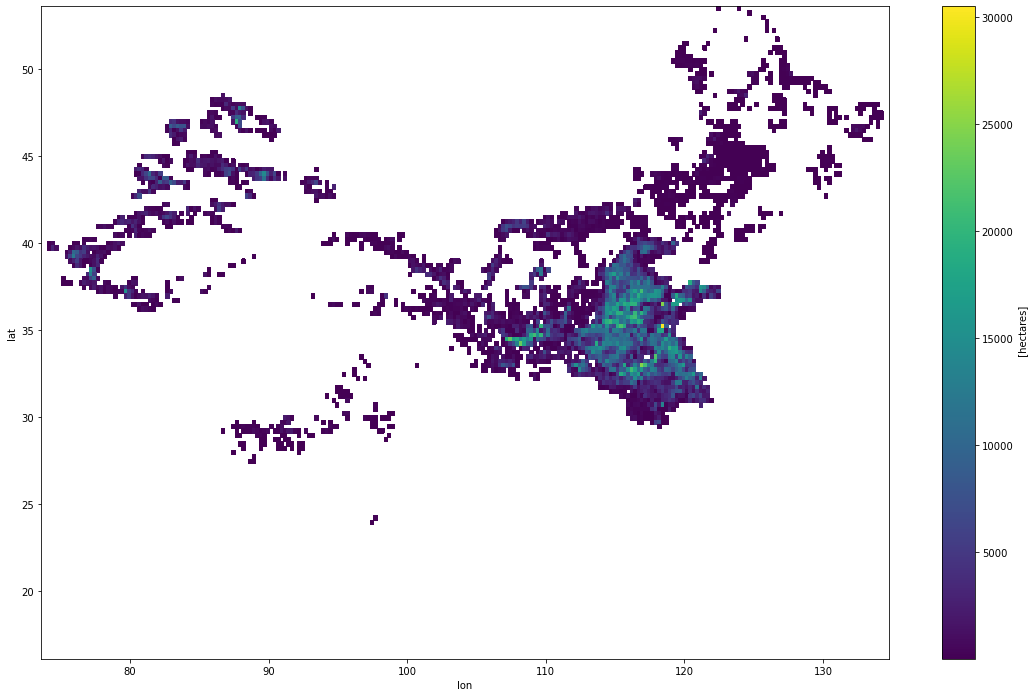

In [191]:
wheatmapirchina.where(wheatmapirchina > 0).plot()

Calculate the proportion irrigated rather than the area irrigated

In [199]:
irrprop = wheatmapirchina.where(wheatmapirchina>0)/wheatmapchina.where(wheatmapchina>0)

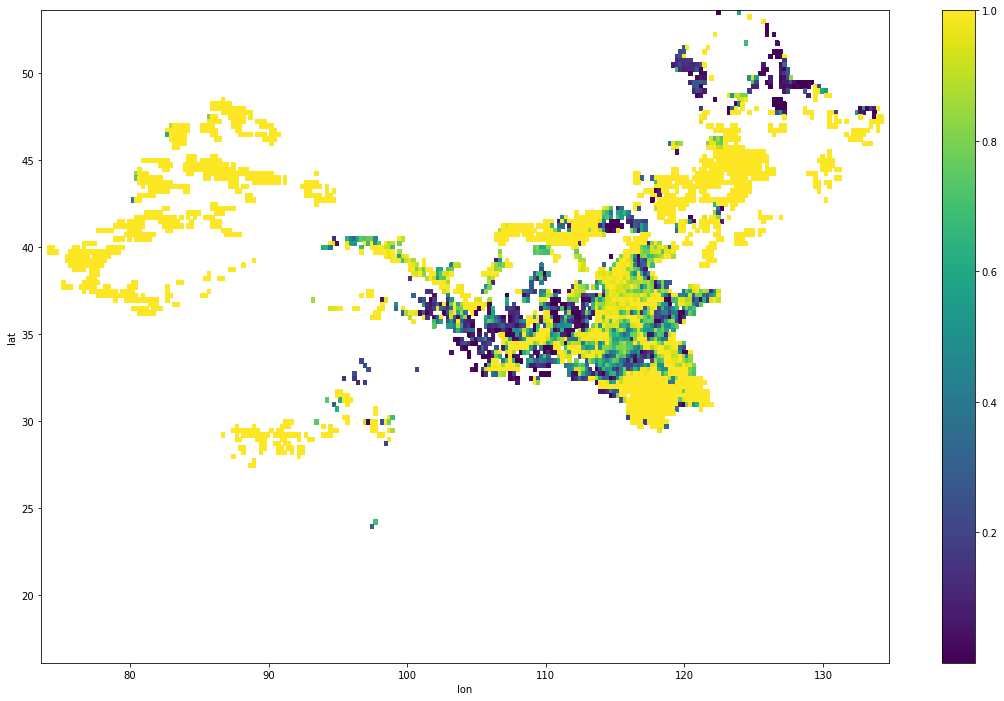

In [200]:
irrprop.plot()

Save to netcdf

In [209]:
irrprop.name = 'wheat_irrigation_proportion'
irrprop.to_netcdf('data/wheat_irrigated_proportion.nc')

---------------

There are 4 steps to producing the standardised anomalies:
- Shift the data onto the growing year calendar if necessary (only for precip/temp)
- Optionally mean or sum the data if needed (e.g. produce 30day rolling sum precip)
- Calculate the long-term mean and stdev (the climatology), including optional smoothing (via rolling means)
- Subtract the mean from the data and divide by the stdev to produce the standardised anomalies

The configuration I settled on for precip:
- 30day rolling total
- 30day rolling mean of the daily long-term standard deviation
- Un-smoothed daily mean for the long-term mean

The configuration I settled on for temperature:
- 10day rolling mean
- 90day rolling mean of the daily long-term standard deviation
- 10day rolling mean of the daily long-term mean

### Calculating rolling means/totals

All the next three code cells do is to save the data as yearly files starting in Oct instead of Jan. So all files will run from Oct->Oct. The year in the filename is the final calendar year spanned by the files, as this is the calendar year that any harvesting would occur in. This is only necessary for the temp/precip, or other driving data.

In [58]:
# years to process and start/end month/day of each file
years = np.arange(1979,1980)
startmonth = 10
startday = 1
endmonth = 9
endday = 30
savedir = '/prj/verdant/matbro/data/growingyears' # where to save the new files

if not os.path.exists(savedir):
    os.makedirs(savedir)

You would need to change this to wherever the data of interest is stored, replacing the year in the filenames as '????'

In [ ]:
alldata = xr.open_mfdataset('data/driving_china/2m_temperature_????.nc')

You would also need to change the filename in savepath below to correspond to the data being processed.

In [10]:
for year in years:
    print('Processing gyear ' + str(year+1))
    gyearp = alldata.sel(time=slice(str(year)+'-'+str(startmonth)+'-'+str(startday), \
                           str(year+1)+'-'+str(endmonth)+'-'+str(endday)))
    savepath = os.path.join(savedir, '2m_temperature_gyear' + str(year+1) + '.nc')
    gyearp.to_netcdf(savepath)

Processing gyear 1980


Now we calculate the rolling means/totals. NOT anomalies or climatologies. Just the rolling mean/sum for each growing year file. Change the 5 variables and years run below as you need to.

In [9]:
outvar = 'precip' # name of the variable in the input file
actdir = 'data/growingyears/' # where the files are stored (and where the output will go)
filestart = 'APHRO_MA_025deg_V1101_gyear' # the bit before the year in the filename
days = 30 # the rolling period
method = 'sum' # mean or sum

for year in range(1980, 2015):
    print('Processing year ' + str(year))
    filename = filestart + str(year) + '.nc'
    actual = xr.load_dataset(os.path.join(actdir, filename))[outvar]
    if method=='mean':
        rolled = actual.rolling(time=days, min_periods=1).mean()
    elif method=='sum':
        rolled = actual.rolling(time=days, min_periods=1).sum()
    rolled.name = outvar
    outname = os.path.join(actdir, filestart + str(year) + '_' + str(days) + 'roll' + method + '.nc')
    rolled.to_netcdf(outname)

Processing year 1980
Processing year 1981
Processing year 1982
Processing year 1983
Processing year 1984
Processing year 1985
Processing year 1986
Processing year 1987
Processing year 1988
Processing year 1989
Processing year 1990
Processing year 1991
Processing year 1992
Processing year 1993
Processing year 1994
Processing year 1995
Processing year 1996
Processing year 1997
Processing year 1998
Processing year 1999
Processing year 2000
Processing year 2001
Processing year 2002
Processing year 2003
Processing year 2004
Processing year 2005
Processing year 2006
Processing year 2007
Processing year 2008
Processing year 2009
Processing year 2010
Processing year 2011
Processing year 2012
Processing year 2013
Processing year 2014


### Producing climatologies

#### Precip and temp

Run the below cell for detail on the calc_daily_climo function. It is used to calculate climatologies of the driving and output data, inclulding smoothing the produced mean and stdev by 'rolling meaning' it

In [59]:
calc_daily_climo?

In [13]:
calc_daily_climo('data/growingyears/APHRO_MA_025deg_V1101_gyear????_30rollsum.nc',
                 'data/growingyears/APHRO_MA_025deg_V1101_gyear1980-2014day_30rollsum',
                 'precip', 'time', xname='lon', yname='lat', roll=30)

In [16]:
calc_daily_climo('data/growingyears/2m_temperature_gyear????.nc',
                 'data/growingyears/2m_temperature_gyears1980-2015day',
                 't2m', 'time', xname='longitude', yname='latitude', roll=90)

#### Yield

Produce a simple climatology (mean and std) of the yield outputs. As there is only one value (per grid square) per year, this is more straightfoward than the other outputs (no rolling smoothing necessary)! You'll just need to change the input and output.

In [26]:
cdo = Cdo()
cdo.timmean(input='-cat outputs/yields/wheat_yields_no_CO2/wheat_era5_aphrodite_noCO2_????.nc', 
            output='outputs/yields/wheat_yields_no_CO2/wheat_era5_aphrodite_noCO2_1980-2014climo.nc')
#cdo.timmean(input='-cat outputs/yields/wheat_yields/WLyields_wheat_era5_aphrodite_????.nc', 
#            output='outputs/yields/wheat_yields/WLyields_wheat_era5_aphrodite_1980-2014climo.nc')
cdo.timstd(input='-cat outputs/yields/wheat_yields_no_CO2/wheat_era5_aphrodite_noCO2_????.nc', 
            output='outputs/yields/wheat_yields_no_CO2/wheat_era5_aphrodite_noCO2_1980-2014stdev.nc')
#cdo.timstd(input='-cat outputs/yields/wheat_yields/WLyields_wheat_era5_aphrodite_????.nc', 
#            output='outputs/yields/wheat_yields/WLyields_wheat_era5_aphrodite_1980-2014stdev.nc')

'outputs/yields/wheat_yields_no_CO2/wheat_era5_aphrodite_noCO2_1980-2014stdev.nc'

#### Biomass

In [40]:
# the location of the files we want to produce a climo of, from the crop model,
# and where to store the produced climatologies
outloc = 'outputs/yields/wheat_yields_no_irr' 

Calculate the climatology (mean and stdev) of the water-unlimited biomass, water-limited biomass and biomass deficit, with no smoothing. You'll just need to change outdir and then the input/output filenames to run with your own files.

In [38]:
calc_daily_climo(os.path.join(outloc, 'WUbiomass_wheat_era5_aphrodite_????.nc'),
                 os.path.join(outloc, 'WUbiomass_wheat_era5_aphrodite_1981-2014'),
                 'WU_Biomass', 't')
calc_daily_climo(os.path.join(outloc, 'WLbiomass_wheat_era5_aphrodite_????.nc'),
                 os.path.join(outloc, 'WLbiomass_wheat_era5_aphrodite_1981-2014'),
                 'WL_Biomass', 't')    
calc_daily_climo(os.path.join(outloc, 'biomass_deficit_wheat_era5_aphrodite_????.nc'),
                 os.path.join(outloc, 'biomass_deficit_wheat_era5_aphrodite_1981-2014'),
                 'WU_Biomass', 't')

Calculate the climatology (mean and stdev) of the water-unlimited and water-limitied biomasses, with a 10-day rolling mean smoothing.

In [45]:
calc_daily_climo(os.path.join(outloc, 'WUbiomass_wheat_era5_aphrodite_????sum.nc'),
                 os.path.join(outloc, 'WUbiomass_wheat_era5_aphrodite_1981-2014sum_'),
                 'WU_Biomass', 't', roll=10)
calc_daily_climo(os.path.join(outloc, 'WLbiomass_wheat_era5_aphrodite_????sum.nc'),
                 os.path.join(outloc, 'WLbiomass_wheat_era5_aphrodite_1981-2014sum_'),
                 'WL_Biomass', 't', roll=10)

### Calculating daily climo anomalies

Calculate the anomalies from the climatologies calculated above in standardised units (standard deviations).

In [14]:
# path of the climatological mean file:
climname = 'data/growingyears/APHRO_MA_025deg_V1101_gyear1980-2014day_30rollsum_climo.nc'
# path of the climatological stdev file:
stdevname = 'data/growingyears/APHRO_MA_025deg_V1101_gyear1980-2014day_30rollsum_30daystdev.nc'
# name of the variable in the climatological files:
outvar = 'precip'
# directory containing the data we want to calculate the anomalies for,
# and where the output anomalies will go:
actdir = 'data/growingyears'
# bit before the year in the filename of these files:
filestart = 'APHRO_MA_025deg_V1101_gyear'
# bit after the year in the filename of these files (not including the .nc extension):
fileID = '_30rollsum'

climo = xr.load_dataset(climname)[outvar]
stdev = xr.load_dataset(stdevname)[outvar]
climotind = list(climo.shape).index(366)
climotname = climo.dims[climotind]
climyear = climo[climotname][-1].dt.year.values
noleapclimo = climo.drop_sel({climotname: np.datetime64(str(climyear)+'-02-29')})
noleapstdev = stdev.drop_sel({climotname: np.datetime64(str(climyear)+'-02-29')})

for year in range(1981, 2015):
    print('Processing year ' + str(year))
    filename = filestart + str(year) + fileID + '.nc'
    actual = xr.load_dataset(os.path.join(actdir, filename))[outvar]

    # Make time dim names the same
    if calendar.isleap(year):
        climotind = list(climo.shape).index(366)
        actualtind = list(actual.shape).index(366)
        actualtname = actual.dims[actualtind]
        climotname = climo.dims[climotind]
        climo = climo.rename({climotname: actualtname})
        stdev = stdev.rename({climotname: actualtname})
        climo = climo.assign_coords({actualtname: actual[actualtname].values})
        stdev = stdev.assign_coords({actualtname: actual[actualtname].values})
    else:
        climotind = list(noleapclimo.shape).index(365)
        actualtind = list(actual.shape).index(365)
        actualtname = actual.dims[actualtind]
        climotname = noleapclimo.dims[climotind]
        noleapclimo = noleapclimo.rename({climotname: actualtname})
        noleapstdev = noleapstdev.rename({climotname: actualtname})
        noleapclimo = noleapclimo.assign_coords({actualtname: actual[actualtname].values})
        noleapstdev = noleapstdev.assign_coords({actualtname: actual[actualtname].values})

    # calculate anomaly
    if calendar.isleap(year):
        anom = actual - climo
        stdevs = anom/stdev
    else:
        anom = actual - noleapclimo
        stdevs = anom/noleapstdev
        
    # save to disk
    anom.name = outvar + '_anomaly'
    stdevs.name = outvar + '_stdev'
    anomsavename  = os.path.join(actdir, filename[:-3] + '_dayanom.nc')
    stdevsavename = os.path.join(actdir, filename[:-3] + '_daystdev.nc')
    anom.to_netcdf(anomsavename)
    stdevs.to_netcdf(stdevsavename)

Processing year 1981
Processing year 1982
Processing year 1983
Processing year 1984
Processing year 1985
Processing year 1986
Processing year 1987
Processing year 1988
Processing year 1989
Processing year 1990
Processing year 1991
Processing year 1992
Processing year 1993
Processing year 1994
Processing year 1995
Processing year 1996
Processing year 1997
Processing year 1998
Processing year 1999
Processing year 2000
Processing year 2001
Processing year 2002
Processing year 2003
Processing year 2004
Processing year 2005
Processing year 2006
Processing year 2007
Processing year 2008
Processing year 2009
Processing year 2010
Processing year 2011
Processing year 2012
Processing year 2013
Processing year 2014


Now the files necessary for the '6-plot summary' have been produced. The code for producing these plots for multiple years is in the '6plot_summary_multianim.py' file, as it takes a while to complete one year, so to do all of them in a reasonable time it needs to be done in parallel, which is not possible in a notebook. See instructions within this file for how to run it.

To produce the animation for just a single year, you can use the code below:

In [ ]:
# Variables to edit:
# year      - The growing year to plot (inclusive)
# boxes     - The lon/lat coords of boxes to draw on the plots
# minval    - The minimum value of the colourbars
# maxval    - The maximum value of the colourbars
# colmaps   - The colourmaps to use for the colours for each plot
#             (left to right, top to bottom)
# lonnames  - Name of the x coords in the files for the plots
# latnames  - Name of the y coords in the files for the plots
# tnames    - Name of the t coords in the files for the plots
# titles    - Titles to give each of the six plots
# files     - Path of the files used in the plots, with ????
#             in place of the year
# outdir    - Where to store the output animations (as mp4s)
########################################################################

year = 1981
#         lonmin,lonmax, latmin,latmax
boxes = [[106.57,109.21, 40.26,41.38], # Hetao
         [108.78,109.66, 23.05,23.51]] # Guangxi
minval = -4
maxval = 4
colmaps = ['bwr_r', 'bwr_r', 'bwr', 'bwr_r', 'bwr_r', 'bwr']
lonnames = ['x', 'x', 'x', 'x', 'lon', 'longitude']
latnames = ['y', 'y', 'y', 'y', 'lat', 'latitude']
tnames = ['t', 't', 't', 'time', 'time', 'time']
titles = ['Water limited biomass anomaly',
          'Water unlimited biomass anomaly',
          'Biomass deficit anomaly',
          'Final yield anomaly',
          '30day rolling-total precip anomaly',
          '10day rolling-mean temp anomaly']
files = ['outputs/yields/wheat_yields_no_irr/WLbiomass_wheat_era5_aphrodite_????sum_stdev.nc',
         'outputs/yields/wheat_yields_no_irr/WUbiomass_wheat_era5_aphrodite_????sum_stdev.nc',
         'outputs/yields/wheat_yields_no_irr/biomass_deficit_wheat_era5_aphrodite_????stdev.nc',
         'outputs/yields/wheat_yields_no_CO2/wheat_era5_aphrodite_noCO2_????stdev.nc',
         'data/growingyears/APHRO_MA_025deg_V1101_gyear????_30rollsum_daystdev.nc',
         'data/growingyears/2m_temperature_gyear????_10rollmean_daystdev.nc']
outdir = 'outputs/plots/summaries'

startdate = str(year-1) + '-10-01'
files2 = [str(year).join(f.split('????')) for f in files]
plot6_summary(files2, year, titles, lonnames, latnames, tnames, 
              startdate, minval, maxval, colmaps, outdir, boxes)



### Other plots

#### Yield plots for all years

Plot just the yield anomalies for each year. Code can be adapted to plot other variables.

In [101]:
# path of the files to plot. Use ???? or other wildcards to select them all
# Code will plot all files selected here
filenames = '/prj/verdant/matbro/outputs/yields/wheat_yields_no_CO2/wheat_era5_aphrodite_noCO2_????stdev.nc'
# name of the variable within the files to plot
varname = 'yield'
# where to save the plots
savedir = '/prj/verdant/matbro/outputs/plots/wheat_yields_no_CO2'
# colourbar limits
clims = [-4, 4]
# colourmap
cmap = 'bwr_r'

In [102]:
files = glob.glob(filenames)

sfname = shapereader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')

if not os.path.exists(savedir):
    os.mkdir(savedir)
    
for ds in files:
    print('Plotting ' + ds)
    try:
        yields = xr.load_dataarray(ds)
    except ValueError:
        yields = xr.load_dataset(ds)[varname]
    #yields = yields.where(yields>0)
    maskedyield = country_subset_shapefile(data=yields, sfname=sfname, IDname='ADMIN', IDs=['China'], drop=1)

    ax = plt.axes(projection=cp.crs.PlateCarree())
    countries = cp.feature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m', edgecolor='black', facecolor='none')
    ax.add_feature(countries)
    if clims[0] is not None and clims[1] is not None:
        maskedyield.plot(cmap=cmap, vmin=clims[0], vmax=clims[1])
        print('both clims')
    elif clims[0] is not None:
        maskedyield.plot(cmap=cmap, vmin=clims[0])
        print('lower clim')
    elif clims[1] is not None:
        maskedyield.plot(cmap=cmap, vmax=clims[1])
        print('upper clim')
    else:
        maskedyield.plot(cmap=cmap)
    gl = ax.gridlines(crs=cp.crs.PlateCarree(), draw_labels=True, alpha=0)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = cp.mpl.gridliner.LONGITUDE_FORMATTER
    gl.yformatter = cp.mpl.gridliner.LATITUDE_FORMATTER
    outname = ''.join(os.path.basename(ds).split('.')[:-1])
    plt.title(outname)
    print(outname)
    outname = os.path.join(savedir, outname + '.png')
    plt.savefig(outname, dpi=300)
    plt.close()

#### Biomass/biomass differences through time

Animation of just the biomass or biomass differences through time. Again, code can be adapted to plot any timeseries netcdf file.

In [11]:
# name of file to animate
filename = '/prj/verdant/matbro/data/growingyears/APHRO_MA_025deg_V1101_gyear1980-2014daycumsum_stdev.nc'
# variable name in file
varname='precip'
# where to save the animation
savedir = '/prj/verdant/matbro/outputs/plots/wheat_yields_no_irr'
# colourlimits ('None' lets matplotlib work it out automaticaly)
clims=['None', 'None']
# colormap
cmap='YlGn'

In [62]:
# run this to see how to use the plot_yearanim function
plot_yearanim?

In [15]:
data = xr.load_dataset(filename)[varname]
plot_yearanim(data, 'lon', 'lat', 'time', '2003-10-01', None, varname,
              os.path.join(savedir, varname), None,
              clims[0], clims[1], cmap, 'mp4', 1)

Plotting frame 1
Plotting frame 1
Plotting frame 1
Plotting frame 2
Plotting frame 3
Plotting frame 4
Plotting frame 5
Plotting frame 6
Plotting frame 7
Plotting frame 8
Plotting frame 9
Plotting frame 10
Plotting frame 11
Plotting frame 12
Plotting frame 13
Plotting frame 14
Plotting frame 15
Plotting frame 16
Plotting frame 17
Plotting frame 18
Plotting frame 19
Plotting frame 20
Plotting frame 21
Plotting frame 22
Plotting frame 23
Plotting frame 24
Plotting frame 25
Plotting frame 26
Plotting frame 27
Plotting frame 28
Plotting frame 29
Plotting frame 30
Plotting frame 31
Plotting frame 32
Plotting frame 33
Plotting frame 34
Plotting frame 35
Plotting frame 36
Plotting frame 37
Plotting frame 38
Plotting frame 39
Plotting frame 40
Plotting frame 41
Plotting frame 42
Plotting frame 43
Plotting frame 44
Plotting frame 45
Plotting frame 46
Plotting frame 47
Plotting frame 48
Plotting frame 49
Plotting frame 50
Plotting frame 51
Plotting frame 52
Plotting frame 53
Plotting frame 54
Plo

#### Plotting time-series of points selected from dataset

Use to plot the timeseries of several coords on one plot, or one coord at several years

##### Biomass sum deficit

Convert time coordinate for easier plotting

In [34]:
tc = xr.load_dataset('outputs/yields/wheat_yields_no_irr/biomass_deficit_wheat_era5_aphrodite_1981-2014climo.nc')
tc = tc.roll(t=-274, roll_coords=True)
newtc = pd.date_range('2003-10-01', freq='D', periods=366)
tc['Biomass_deficit_sum'] = xr.DataArray(tc['WU_Biomass'].values, [newtc, tc['y'], tc['x']], ['time', 'y', 'x'])
tc = tc.drop_vars(['WU_Biomass', 't'])
tc.to_netcdf('outputs/yields/wheat_yields_no_irr/biomass_deficit_wheat_era5_aphrodite_1981-2014climo.nc')

In [64]:
# Run to see how plot_points works
plot_points?

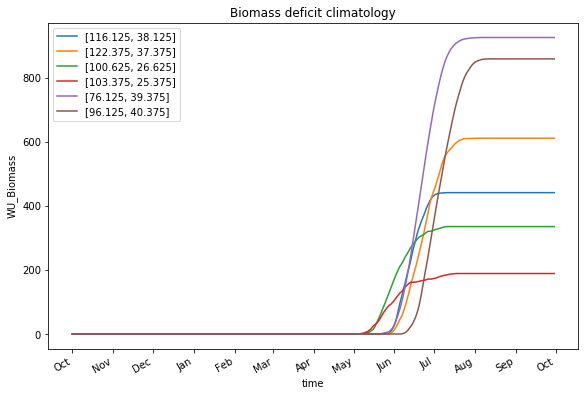

In [42]:
# file(s) to plot
datalist = ['outputs/yields/wheat_yields_no_irr/biomass_deficit_wheat_era5_aphrodite_1981-2014climo.nc']
# name of variable(s) to plot
varnames = ['WU_Biomass']
# coordinates to plot
coords = [[116.125, 38.125],
          [122.375, 37.375],
          [100.625, 26.625],
          [103.375, 25.375],
          [76.125, 39.375],
          [96.125, 40.375]]
xname = 'x'
yname = 'y'
tname = 'time' # coord/dimension names in the netcdf file
# where to save the output plot
outdir = '/prj/verdant/matbro/outputs/plots/wheat_yields_no_irr/biomass_diff/'

plot_points(datalist, varnames, coords, xname, yname, tname, outdir, title='Biomass deficit climatology', year='climo')

##### Precip

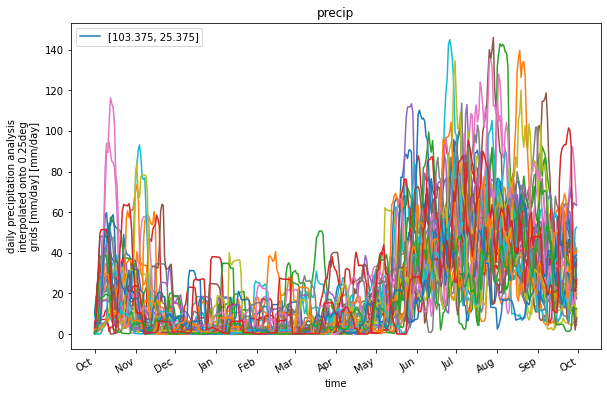

In [14]:
datalist = []
for year in range(1981, 2015):
    datalist.append('data/growingyears/APHRO_MA_025deg_V1101_gyear' + str(year) + '_10rollsum.nc')

varnames = 'precip'
coords = [#[116.125, 38.125],
          #[122.375, 37.375],
          #[100.625, 26.625],
          [103.375, 25.375],
          #[76.125, 39.375],
          #[96.125, 40.375]
           ]
xname = 'lon'
yname = 'lat'
tname = 'time'
outdir = 'outputs/plots/'

mean, stdev = plot_points(datalist, varnames, coords, xname, yname, tname, outdir, year='climo', startdate='10-01')

#### Crop model plots

Various plots of the outputs of the crop model. These are mainly left here for reference. Probably best not to try and rerun the code cells as I can't guarantee the data files they used are still in the same place!

Found: China
Adding mask to xarray


Text(0.5, 1.0, 'Wheat yield with ERA5 2015 (tn/hec)')

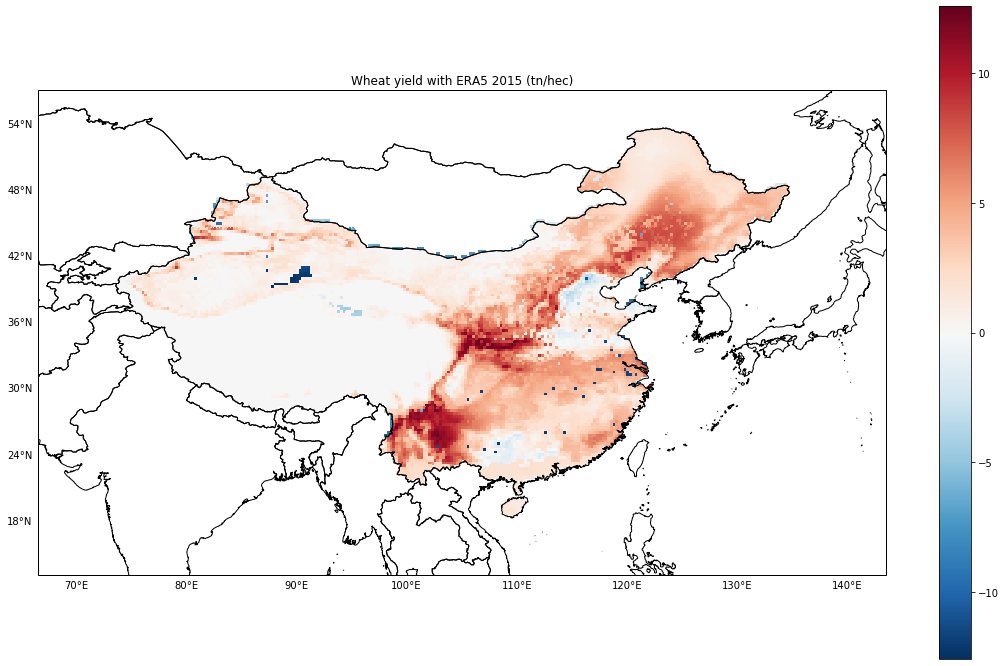

In [167]:
sfname = shapereader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')

yieldswheat = xr.load_dataarray('/prj/verdant/matbro/yieldtest.nc')

#yieldsw = yieldswheat.where(yieldswheat>0)\
#                     .where(yieldswheat.y > 15, drop=True)\
#                     .where(yieldswheat.x > 70, drop=True)\
#                     .where(yieldswheat.x < 140, drop=True).T

yieldsw = yieldswheat.where(yieldswheat.y > 15, drop=True)\
                     .where(yieldswheat.x > 70, drop=True)\
                     .where(yieldswheat.x < 140, drop=True).T

maskedyield = catchment_subset_shapefile(data=yieldsw, sfname=sfname, IDname='ADMIN', IDs=['China'])

ax = plt.axes(projection=cp.crs.PlateCarree())
countries = cp.feature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m', edgecolor='black', facecolor='none')
ax.add_feature(countries)
maskedyield.plot()
gl = ax.gridlines(crs=cp.crs.PlateCarree(), draw_labels=True, alpha=0)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = cp.mpl.gridliner.LONGITUDE_FORMATTER
gl.yformatter = cp.mpl.gridliner.LATITUDE_FORMATTER
plt.title('Wheat yield with ERA5 2015 (tn/hec)')
#plt.savefig('yield_era5_china.png', dpi=300)

Found: China
Adding mask to xarray


Text(0.5, 1.0, 'Wheat yield with ERA5 and Aphrodite 2015 (tn/hec)')

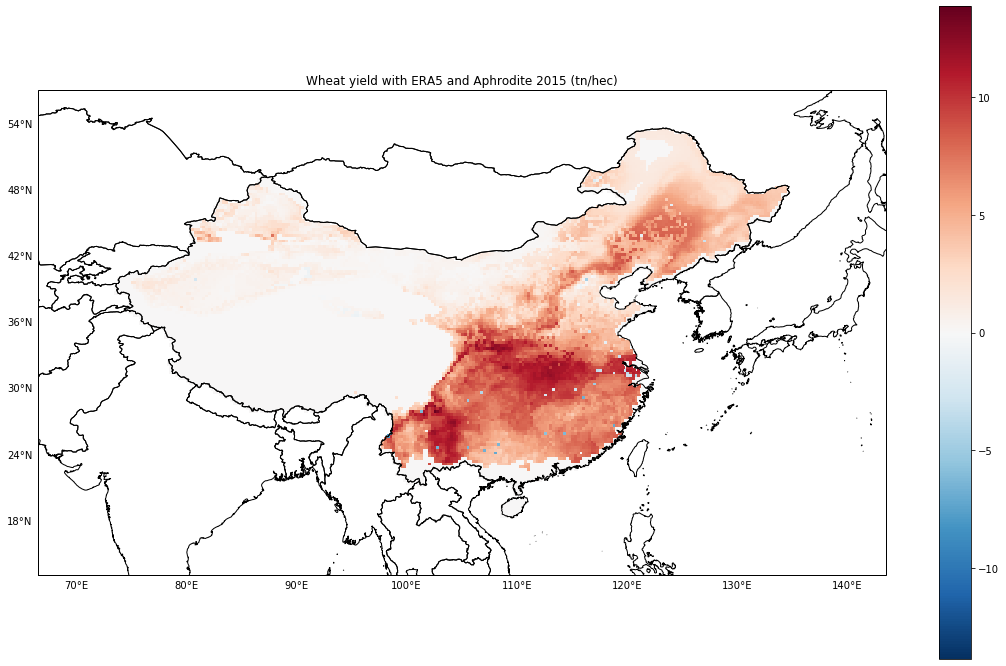

In [181]:
sfname = shapereader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')

yieldswheat = xr.load_dataarray('/prj/verdant/matbro/wheatyield2.nc')

#yieldsw = yieldswheat.where(yieldswheat>0)\
#                     .where(yieldswheat.y > 15, drop=True)\
#                     .where(yieldswheat.x > 70, drop=True)\
#                     .where(yieldswheat.x < 140, drop=True).T

yieldswea = yieldswheat.where(yieldswheat.y > 15, drop=True)\
                     .where(yieldswheat.x > 70, drop=True)\
                     .where(yieldswheat.x < 140, drop=True).T

maskedyield = catchment_subset_shapefile(data=yieldswea, sfname=sfname, IDname='ADMIN', IDs=['China'])

ax = plt.axes(projection=cp.crs.PlateCarree())
countries = cp.feature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m', edgecolor='black', facecolor='none')
ax.add_feature(countries)
maskedyield.plot()
gl = ax.gridlines(crs=cp.crs.PlateCarree(), draw_labels=True, alpha=0)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = cp.mpl.gridliner.LONGITUDE_FORMATTER
gl.yformatter = cp.mpl.gridliner.LATITUDE_FORMATTER
plt.title('Wheat yield with ERA5 and Aphrodite 2015 (tn/hec)')
#plt.savefig('wheat_yield_era5_aphrodite_china.png', dpi=300)

Found: China
Adding mask to xarray


Text(0.5, 1.0, 'Water-limited wheat yield with ERA5 and Aphrodite 2015 (no waterlogging) (tn/hec)')

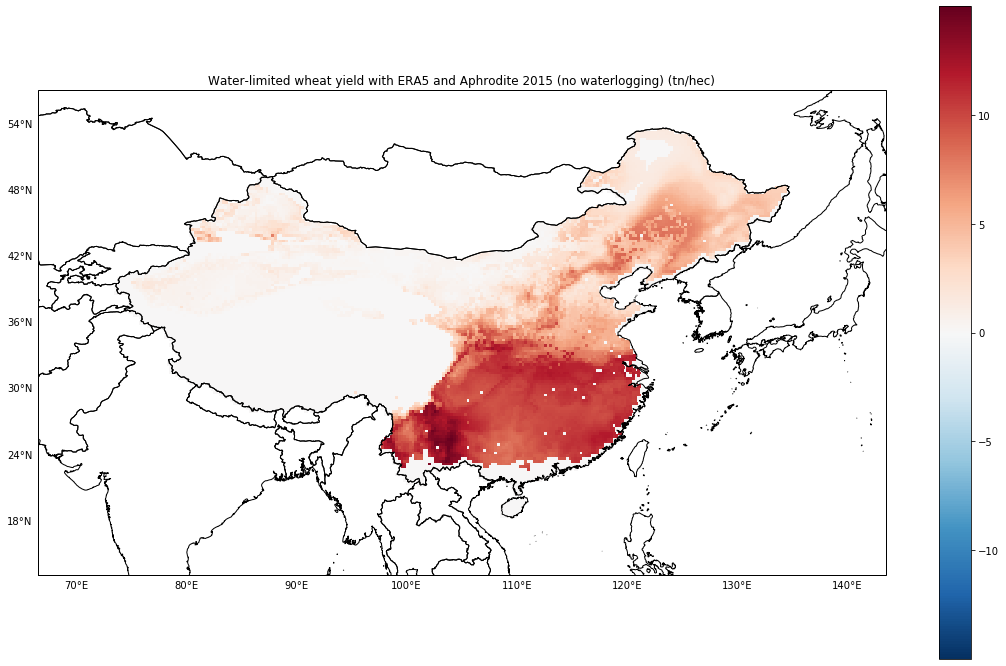

In [170]:
sfname = shapereader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')

yieldswheat = xr.load_dataarray('/prj/verdant/matbro/wheat_WLyield_era5_aphrodite.nc')

#yieldsw = yieldswheat.where(yieldswheat>0)\
#                     .where(yieldswheat.y > 15, drop=True)\
#                     .where(yieldswheat.x > 70, drop=True)\
#                     .where(yieldswheat.x < 140, drop=True).T

wyieldsnowaterlog = yieldswheat.where(yieldswheat.y > 15, drop=True)\
                     .where(yieldswheat.x > 70, drop=True)\
                     .where(yieldswheat.x < 140, drop=True).T

maskedyield = catchment_subset_shapefile(data=wyieldsnowaterlog, sfname=sfname, IDname='ADMIN', IDs=['China'])

ax = plt.axes(projection=cp.crs.PlateCarree())
countries = cp.feature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m', edgecolor='black', facecolor='none')
ax.add_feature(countries)
maskedyield.plot()
gl = ax.gridlines(crs=cp.crs.PlateCarree(), draw_labels=True, alpha=0)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = cp.mpl.gridliner.LONGITUDE_FORMATTER
gl.yformatter = cp.mpl.gridliner.LATITUDE_FORMATTER
plt.title('Water-limited wheat yield with ERA5 and Aphrodite 2015 (no waterlogging) (tn/hec)')
#plt.savefig('wheat_WLyield_era5_aphrodite_china_nowaterlogging.png', dpi=300)

Found: China
Adding mask to xarray


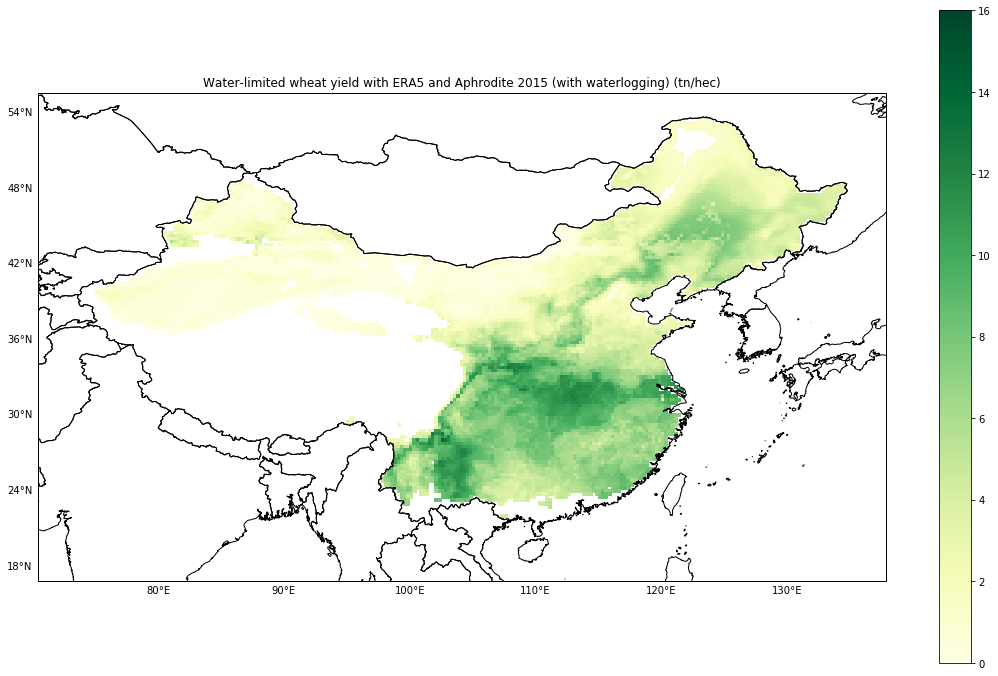

In [274]:
sfname = shapereader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')

yieldswheat = xr.load_dataarray('/prj/verdant/matbro/wheat_WLyield_era5_aphrodite_waterlogging.nc')

wyieldswaterlog = yieldswheat.where(yieldswheat>0)\
                     .where(yieldswheat.y > 15, drop=True)\
                     .where(yieldswheat.x > 70, drop=True)\
                     .where(yieldswheat.x < 140, drop=True)

maskedyield = catchment_subset_shapefile(data=wyieldswaterlog, sfname=sfname, IDname='ADMIN', IDs=['China'])

ax = plt.axes(projection=cp.crs.PlateCarree())
countries = cp.feature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m', edgecolor='black', facecolor='none')
ax.add_feature(countries)
maskedyield.plot(cmap='YlGn', vmin=0, vmax=16)
gl = ax.gridlines(crs=cp.crs.PlateCarree(), draw_labels=True, alpha=0)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = cp.mpl.gridliner.LONGITUDE_FORMATTER
gl.yformatter = cp.mpl.gridliner.LATITUDE_FORMATTER
plt.title('Water-limited wheat yield with ERA5 and Aphrodite 2015 (with waterlogging) (tn/hec)')
plt.savefig('/prj/verdant/matbro/plots/wheat_WLyield_era5_aphrodite_china_waterlogging.png', dpi=300)

Found: China
Adding mask to xarray


Text(0.5, 1.0, 'Water-limited wheat yield with ERA5 and Aphrodite 2015 affect of waterlogging only (tn/hec)')

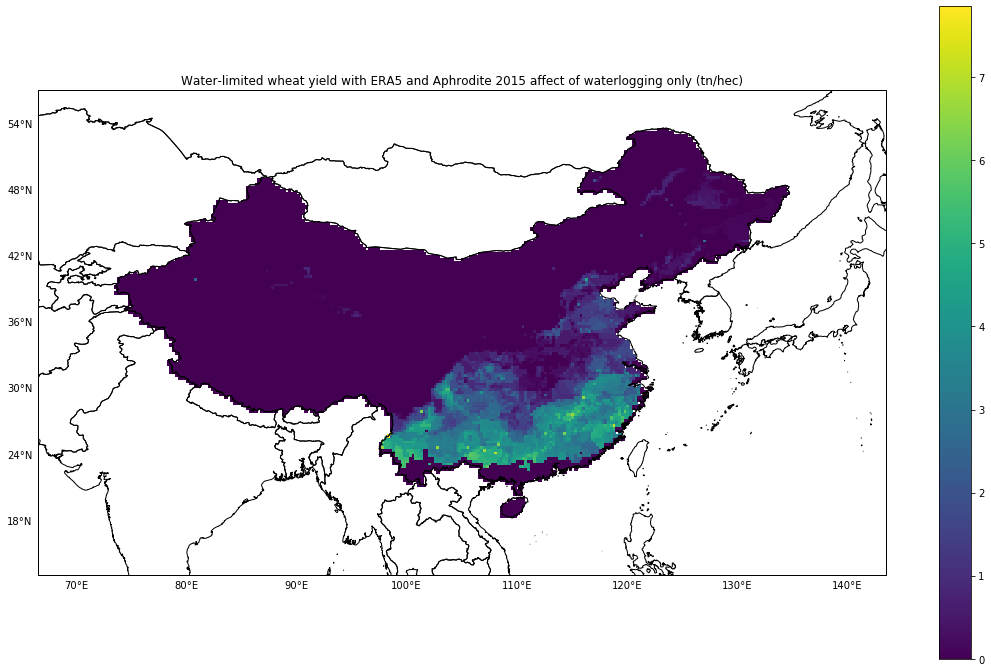

In [190]:
maskedyield = catchment_subset_shapefile(data=(wyieldsnowaterlog - wyieldswaterlog), sfname=sfname, IDname='ADMIN', IDs=['China'])
ax = plt.axes(projection=cp.crs.PlateCarree())
countries = cp.feature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m', edgecolor='black', facecolor='none')
ax.add_feature(countries)
maskedyield.plot()
gl = ax.gridlines(crs=cp.crs.PlateCarree(), draw_labels=True, alpha=0)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = cp.mpl.gridliner.LONGITUDE_FORMATTER
gl.yformatter = cp.mpl.gridliner.LATITUDE_FORMATTER
plt.title('Water-limited wheat yield with ERA5 and Aphrodite 2015 affect of waterlogging only (tn/hec)')

Found: China
Adding mask to xarray


Text(0.5, 1.0, 'Water-limited wheat yield with ERA5 and Aphrodite 2015 (no flower failure) (tn/hec)')

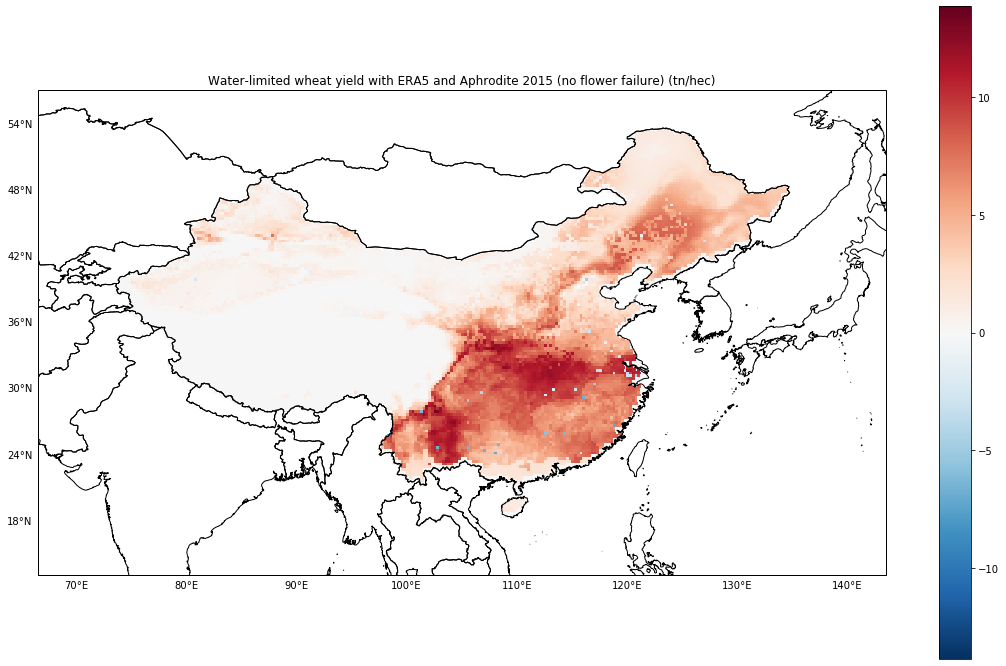

In [198]:
sfname = shapereader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')

yieldswheat = xr.load_dataarray('/prj/verdant/matbro/wheat_WLyield_era5_aphrodite_flowerfailure.nc')

#yieldsw = yieldswheat.where(yieldswheat>0)\
#                     .where(yieldswheat.y > 15, drop=True)\
#                     .where(yieldswheat.x > 70, drop=True)\
#                     .where(yieldswheat.x < 140, drop=True).T

yieldswnff = yieldswheat.where(yieldswheat.y > 15, drop=True)\
                     .where(yieldswheat.x > 70, drop=True)\
                     .where(yieldswheat.x < 140, drop=True).T

maskedyield = catchment_subset_shapefile(data=yieldswnff, sfname=sfname, IDname='ADMIN', IDs=['China'])

ax = plt.axes(projection=cp.crs.PlateCarree())
countries = cp.feature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m', edgecolor='black', facecolor='none')
ax.add_feature(countries)
maskedyield.plot()
gl = ax.gridlines(crs=cp.crs.PlateCarree(), draw_labels=True, alpha=0)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = cp.mpl.gridliner.LONGITUDE_FORMATTER
gl.yformatter = cp.mpl.gridliner.LATITUDE_FORMATTER
plt.title('Water-limited wheat yield with ERA5 and Aphrodite 2015 (no flower failure) (tn/hec)')
#plt.savefig('wheat_WLUield_era5_aphrodite_china_nowaterlogging.png', dpi=300)

Found: China
Adding mask to xarray


Text(0.5, 1.0, 'Water-limited wheat yield with ERA5 and Aphrodite 2015 affect of flower failure only (tn/hec)')

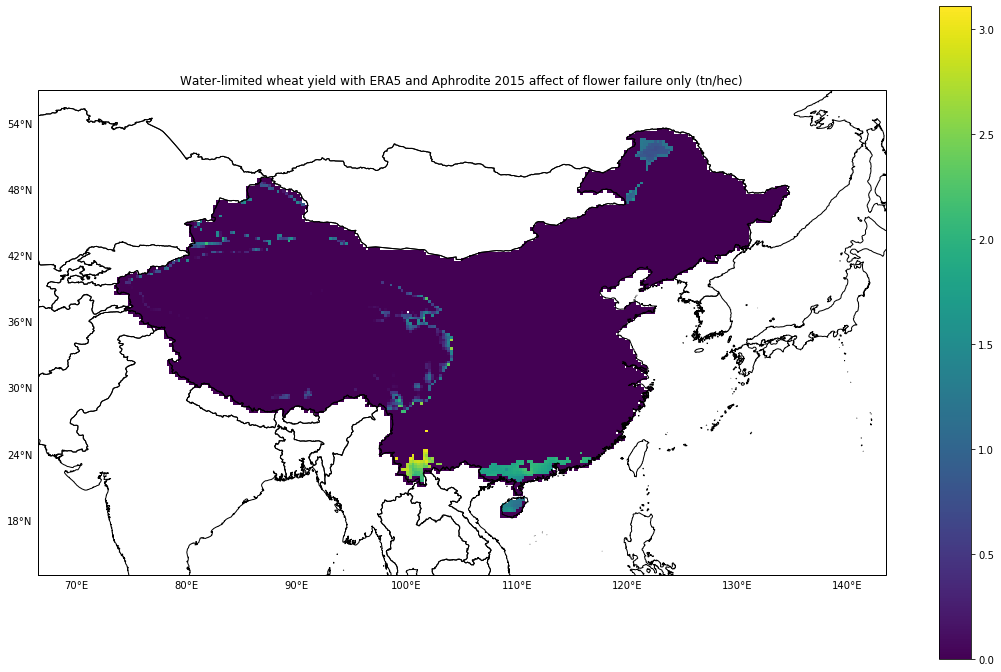

In [189]:
maskedyield = catchment_subset_shapefile(data=(yieldswnff - yieldswea), sfname=sfname, IDname='ADMIN', IDs=['China'])
ax = plt.axes(projection=cp.crs.PlateCarree())
countries = cp.feature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m', edgecolor='black', facecolor='none')
ax.add_feature(countries)
maskedyield.plot()
gl = ax.gridlines(crs=cp.crs.PlateCarree(), draw_labels=True, alpha=0)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = cp.mpl.gridliner.LONGITUDE_FORMATTER
gl.yformatter = cp.mpl.gridliner.LATITUDE_FORMATTER
plt.title('Water-limited wheat yield with ERA5 and Aphrodite 2015 affect of flower failure only (tn/hec)')

Found: China
Adding mask to xarray


Text(0.5, 1.0, 'Water-unlimited wheat yield with ERA5 and Aphrodite 2015 (no waterlogging) (tn/hec)')

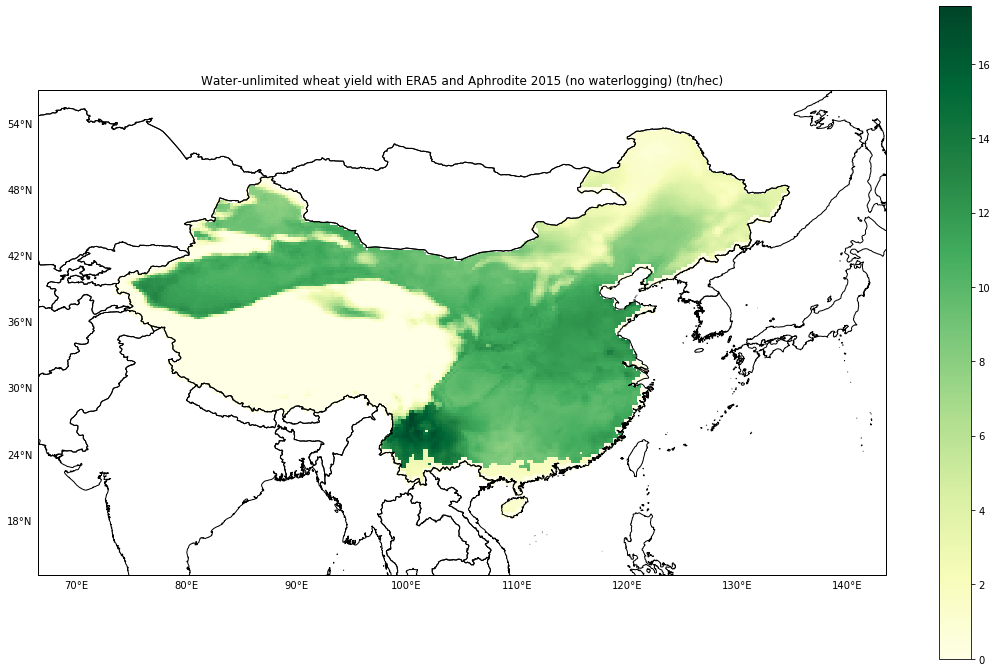

In [186]:
sfname = shapereader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')

yieldswheat = xr.load_dataarray('/prj/verdant/matbro/wheat_WUyield_era5_aphrodite.nc')

#yieldsw = yieldswheat.where(yieldswheat>0)\
#                     .where(yieldswheat.y > 15, drop=True)\
#                     .where(yieldswheat.x > 70, drop=True)\
#                     .where(yieldswheat.x < 140, drop=True).T

yieldswu = yieldswheat.where(yieldswheat.y > 15, drop=True)\
                     .where(yieldswheat.x > 70, drop=True)\
                     .where(yieldswheat.x < 140, drop=True).T

maskedyield = catchment_subset_shapefile(data=yieldswu, sfname=sfname, IDname='ADMIN', IDs=['China'])

ax = plt.axes(projection=cp.crs.PlateCarree())
countries = cp.feature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m', edgecolor='black', facecolor='none')
ax.add_feature(countries)
maskedyield.plot(cmap='YlGn')
gl = ax.gridlines(crs=cp.crs.PlateCarree(), draw_labels=True, alpha=0)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = cp.mpl.gridliner.LONGITUDE_FORMATTER
gl.yformatter = cp.mpl.gridliner.LATITUDE_FORMATTER
plt.title('Water-unlimited wheat yield with ERA5 and Aphrodite 2015 (no waterlogging) (tn/hec)')
#plt.savefig('wheat_WLUield_era5_aphrodite_china_nowaterlogging.png', dpi=300)

Found: China
Adding mask to xarray


Text(0.5, 1.0, 'Wheat yield with ERA5 and Aphrodite 2015 affect of water limitation only (tn/hec)')

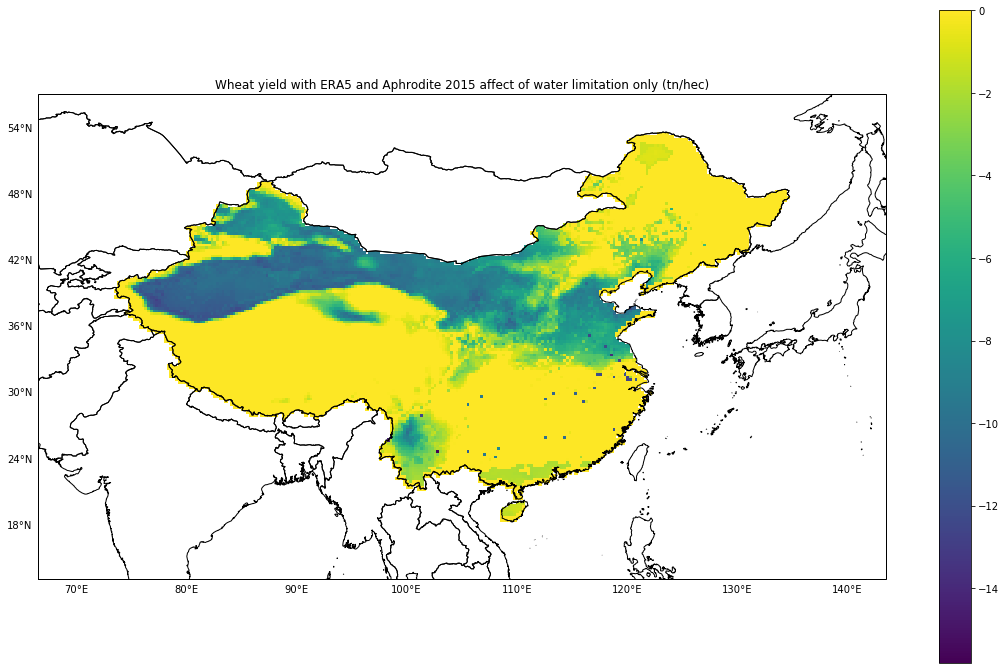

In [188]:
maskedyield = catchment_subset_shapefile(data=(wyieldsnowaterlog - yieldswu), sfname=sfname, IDname='ADMIN', IDs=['China'])
ax = plt.axes(projection=cp.crs.PlateCarree())
countries = cp.feature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m', edgecolor='black', facecolor='none')
ax.add_feature(countries)
maskedyield.plot()
gl = ax.gridlines(crs=cp.crs.PlateCarree(), draw_labels=True, alpha=0)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = cp.mpl.gridliner.LONGITUDE_FORMATTER
gl.yformatter = cp.mpl.gridliner.LATITUDE_FORMATTER
plt.title('Wheat yield with ERA5 and Aphrodite 2015 affect of water limitation only (tn/hec)')

Found: China
Adding mask to xarray


Text(0.5, 1.0, 'Water-unlimited wheat yield with ERA5 and Aphrodite 2015 (waterlogging enabled) (tn/hec)')

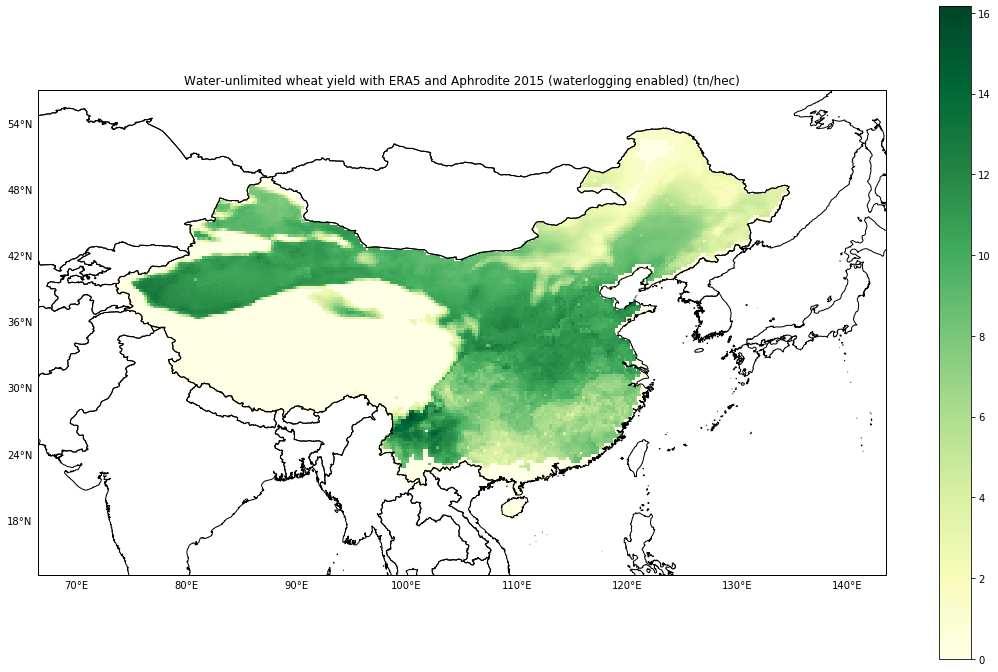

In [192]:
sfname = shapereader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')

yieldswheat = xr.load_dataarray('/prj/verdant/matbro/wheat_WUyield_era5_aphrodite_waterlogging.nc')

#yieldsw = yieldswheat.where(yieldswheat>0)\
#                     .where(yieldswheat.y > 15, drop=True)\
#                     .where(yieldswheat.x > 70, drop=True)\
#                     .where(yieldswheat.x < 140, drop=True).T

yieldswuwl = yieldswheat.where(yieldswheat.y > 15, drop=True)\
                     .where(yieldswheat.x > 70, drop=True)\
                     .where(yieldswheat.x < 140, drop=True).T

maskedyield = catchment_subset_shapefile(data=yieldswuwl, sfname=sfname, IDname='ADMIN', IDs=['China'])

ax = plt.axes(projection=cp.crs.PlateCarree())
countries = cp.feature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m', edgecolor='black', facecolor='none')
ax.add_feature(countries)
maskedyield.plot(cmap='YlGn')
gl = ax.gridlines(crs=cp.crs.PlateCarree(), draw_labels=True, alpha=0)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = cp.mpl.gridliner.LONGITUDE_FORMATTER
gl.yformatter = cp.mpl.gridliner.LATITUDE_FORMATTER
plt.title('Water-unlimited wheat yield with ERA5 and Aphrodite 2015 (waterlogging enabled) (tn/hec)')
#plt.savefig('wheat_WLUield_era5_aphrodite_china_nowaterlogging.png', dpi=300)

Found: China
Adding mask to xarray


Text(0.5, 1.0, 'Water-limited wheat yield with ERA5 and Aphrodite 2015 (waterlogging enabled, high AWC) (tn/hec)')

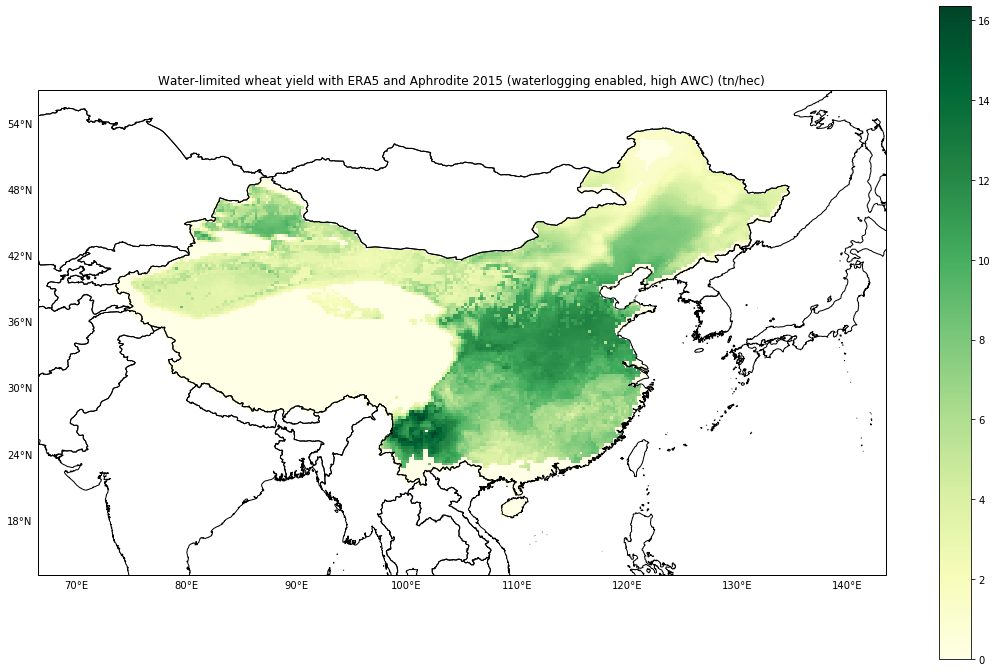

In [197]:
sfname = shapereader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')

yieldswheat = xr.load_dataarray('/prj/verdant/matbro/wheat_WLyield_era5_aphrodite_waterlogging_hiAWC.nc')

#yieldsw = yieldswheat.where(yieldswheat>0)\
#                     .where(yieldswheat.y > 15, drop=True)\
#                     .where(yieldswheat.x > 70, drop=True)\
#                     .where(yieldswheat.x < 140, drop=True).T

yieldswlwlhiAWC = yieldswheat.where(yieldswheat.y > 15, drop=True)\
                     .where(yieldswheat.x > 70, drop=True)\
                     .where(yieldswheat.x < 140, drop=True).T

maskedyield = catchment_subset_shapefile(data=yieldswlwlhiAWC, sfname=sfname, IDname='ADMIN', IDs=['China'])

ax = plt.axes(projection=cp.crs.PlateCarree())
countries = cp.feature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m', edgecolor='black', facecolor='none')
ax.add_feature(countries)
maskedyield.plot(cmap='YlGn')
gl = ax.gridlines(crs=cp.crs.PlateCarree(), draw_labels=True, alpha=0)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = cp.mpl.gridliner.LONGITUDE_FORMATTER
gl.yformatter = cp.mpl.gridliner.LATITUDE_FORMATTER
plt.title('Water-limited wheat yield with ERA5 and Aphrodite 2015 (waterlogging enabled, high AWC) (tn/hec)')
#plt.savefig('wheat_WLUield_era5_aphrodite_china_nowaterlogging.png', dpi=300)

Found: China
Adding mask to xarray


Text(0.5, 1.0, 'Water-limited wheat yield with ERA5 and Aphrodite 2015, affect of increasing AWC by 200 only (tn/hec)')

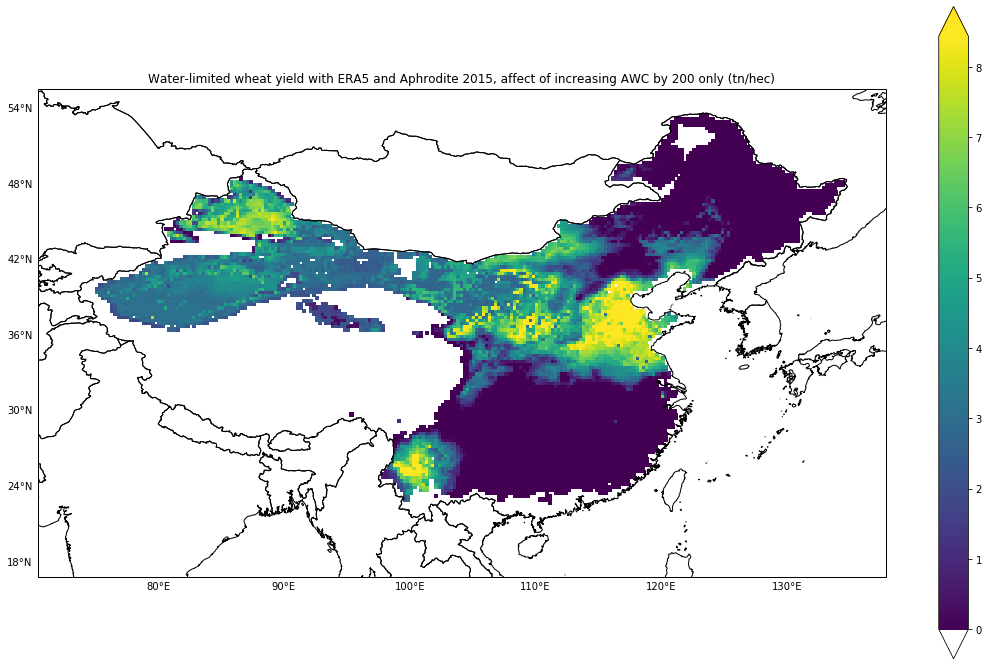

In [290]:
maskedyield = catchment_subset_shapefile(data=(yieldswlwlhiAWC - wyieldswaterlog), sfname=sfname, IDname='ADMIN', IDs=['China'])
ax = plt.axes(projection=cp.crs.PlateCarree())
countries = cp.feature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m', edgecolor='black', facecolor='none')
ax.add_feature(countries)
maskedyield.plot(robust=True)
gl = ax.gridlines(crs=cp.crs.PlateCarree(), draw_labels=True, alpha=0)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = cp.mpl.gridliner.LONGITUDE_FORMATTER
gl.yformatter = cp.mpl.gridliner.LATITUDE_FORMATTER
plt.title('Water-limited wheat yield with ERA5 and Aphrodite 2015, affect of increasing AWC by 200 only (tn/hec)')

Found: China
Adding mask to xarray


Text(0.5, 1.0, 'Water-limited wheat yield with ERA5 and Aphrodite 2015 (waterlogging enabled, v. high AWC) (tn/hec)')

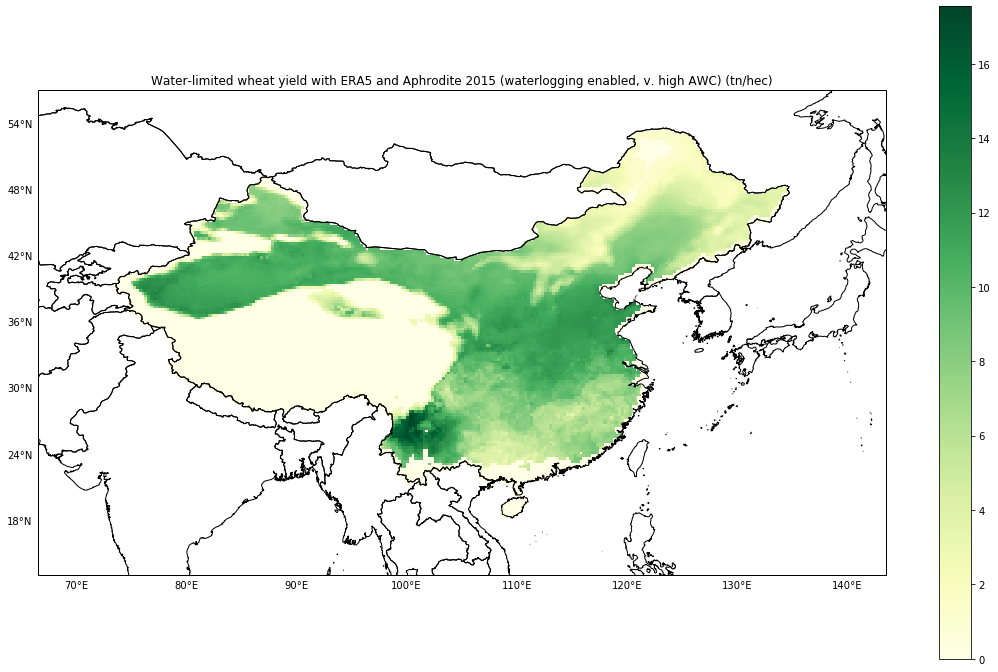

In [201]:
sfname = shapereader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')

yieldswheat = xr.load_dataarray('/prj/verdant/matbro/wheat_WLyield_era5_aphrodite_waterlogging_vhiAWC.nc')

#yieldsw = yieldswheat.where(yieldswheat>0)\
#                     .where(yieldswheat.y > 15, drop=True)\
#                     .where(yieldswheat.x > 70, drop=True)\
#                     .where(yieldswheat.x < 140, drop=True).T

yieldswlwlvhiAWC = yieldswheat.where(yieldswheat.y > 15, drop=True)\
                     .where(yieldswheat.x > 70, drop=True)\
                     .where(yieldswheat.x < 140, drop=True).T

maskedyield = catchment_subset_shapefile(data=yieldswlwlvhiAWC, sfname=sfname, IDname='ADMIN', IDs=['China'])

ax = plt.axes(projection=cp.crs.PlateCarree())
countries = cp.feature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m', edgecolor='black', facecolor='none')
ax.add_feature(countries)
maskedyield.plot(cmap='YlGn')
gl = ax.gridlines(crs=cp.crs.PlateCarree(), draw_labels=True, alpha=0)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = cp.mpl.gridliner.LONGITUDE_FORMATTER
gl.yformatter = cp.mpl.gridliner.LATITUDE_FORMATTER
plt.title('Water-limited wheat yield with ERA5 and Aphrodite 2015 (waterlogging enabled, v. high AWC) (tn/hec)')
#plt.savefig('wheat_WLUield_era5_aphrodite_china_nowaterlogging.png', dpi=300)

Found: China
Adding mask to xarray


Text(0.5, 1.0, 'Water-limited wheat yield with ERA5 and Aphrodite 2015, affect of increasing AWC by 400 only (tn/hec)')

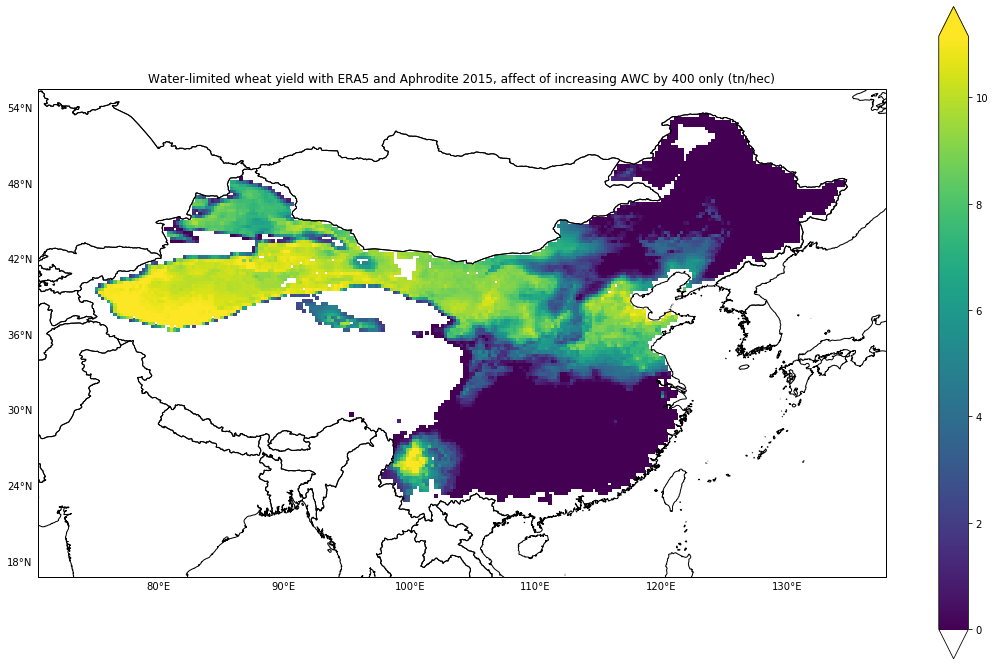

In [291]:
maskedyield = catchment_subset_shapefile(data=(yieldswlwlvhiAWC - wyieldswaterlog), sfname=sfname, IDname='ADMIN', IDs=['China'])
ax = plt.axes(projection=cp.crs.PlateCarree())
countries = cp.feature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m', edgecolor='black', facecolor='none')
ax.add_feature(countries)
maskedyield.plot(robust=True)
gl = ax.gridlines(crs=cp.crs.PlateCarree(), draw_labels=True, alpha=0)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = cp.mpl.gridliner.LONGITUDE_FORMATTER
gl.yformatter = cp.mpl.gridliner.LATITUDE_FORMATTER
plt.title('Water-limited wheat yield with ERA5 and Aphrodite 2015, affect of increasing AWC by 400 only (tn/hec)')

Found: China
Adding mask to xarray


Text(0.5, 1.0, 'Water-limited wheat yield with ERA5 and Aphrodite 2015, affect of increasing AWC by 200 a second time (tn/hec)')

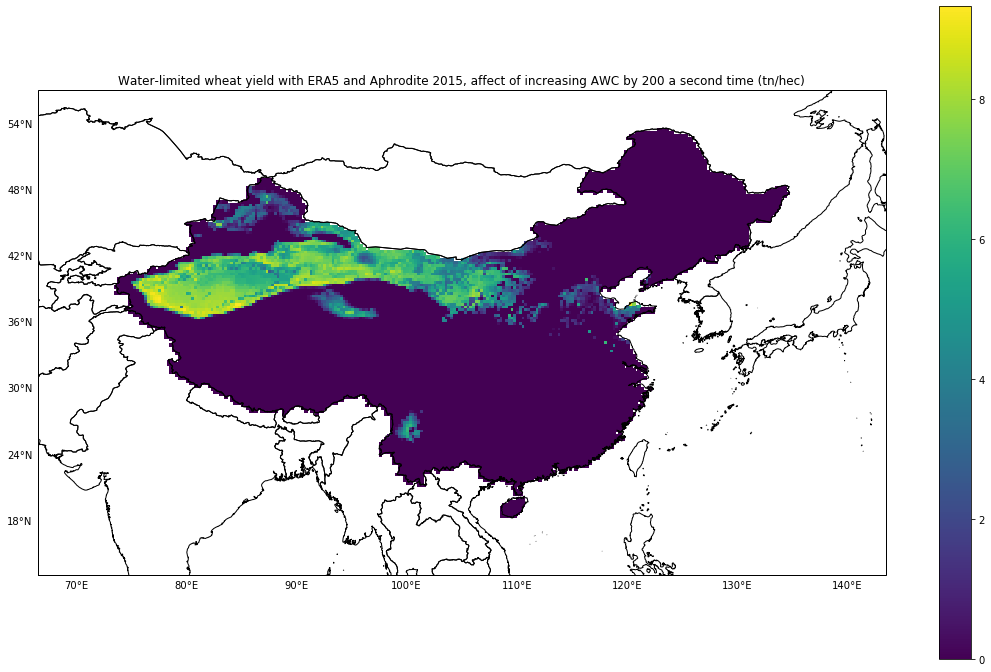

In [204]:
maskedyield = catchment_subset_shapefile(data=(yieldswlwlvhiAWC - yieldswlwlhiAWC), sfname=sfname, IDname='ADMIN', IDs=['China'])
ax = plt.axes(projection=cp.crs.PlateCarree())
countries = cp.feature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m', edgecolor='black', facecolor='none')
ax.add_feature(countries)
maskedyield.plot()
gl = ax.gridlines(crs=cp.crs.PlateCarree(), draw_labels=True, alpha=0)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = cp.mpl.gridliner.LONGITUDE_FORMATTER
gl.yformatter = cp.mpl.gridliner.LATITUDE_FORMATTER
plt.title('Water-limited wheat yield with ERA5 and Aphrodite 2015, affect of increasing AWC by 200 a second time (tn/hec)')

Found: China
Adding mask to xarray


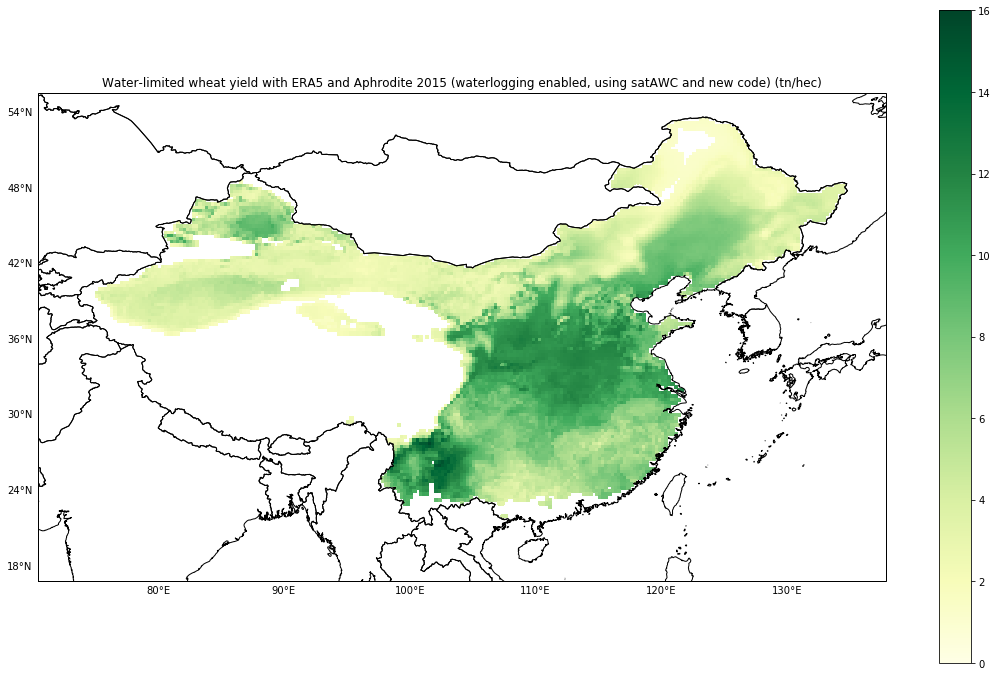

In [273]:
sfname = shapereader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')

yieldswheat = xr.load_dataarray('/prj/verdant/matbro/wheat_WLyield_era5_aphrodite_waterlogging_satAWC_newcode.nc')

yieldsnc = yieldswheat.where(yieldswheat>0)

maskedyield = catchment_subset_shapefile(data=yieldsnc, sfname=sfname, IDname='ADMIN', IDs=['China'])

ax = plt.axes(projection=cp.crs.PlateCarree())
countries = cp.feature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m', edgecolor='black', facecolor='none')
ax.add_feature(countries)
maskedyield.plot(cmap='YlGn', vmin=0, vmax=16)
gl = ax.gridlines(crs=cp.crs.PlateCarree(), draw_labels=True, alpha=0)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = cp.mpl.gridliner.LONGITUDE_FORMATTER
gl.yformatter = cp.mpl.gridliner.LATITUDE_FORMATTER
plt.title('Water-limited wheat yield with ERA5 and Aphrodite 2015 (waterlogging enabled, using satAWC and new code) (tn/hec)')
plt.savefig('/prj/verdant/matbro/plots/wheat_WLYield_era5_aphrodite_china_satAWC_nc.png', dpi=300)

Found: China
Adding mask to xarray


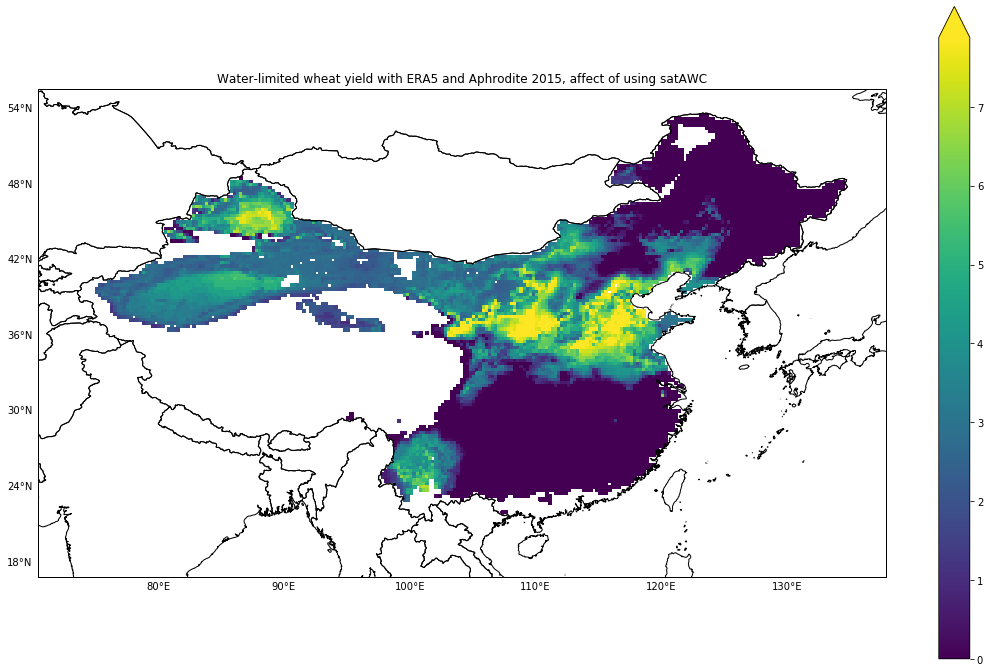

In [294]:
pcdata = ((yieldsnc - wyieldswaterlog)/wyieldswaterlog)*100
diffdata = yieldsnc - wyieldswaterlog
maskedyield = catchment_subset_shapefile(data=diffdata, sfname=sfname, IDname='ADMIN', IDs=['China'])
ax = plt.axes(projection=cp.crs.PlateCarree())
countries = cp.feature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m', edgecolor='black', facecolor='none')
ax.add_feature(countries)
maskedyield.plot(robust=True) # ignore outliers
gl = ax.gridlines(crs=cp.crs.PlateCarree(), draw_labels=True, alpha=0)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = cp.mpl.gridliner.LONGITUDE_FORMATTER
gl.yformatter = cp.mpl.gridliner.LATITUDE_FORMATTER
plt.title('Water-limited wheat yield with ERA5 and Aphrodite 2015, affect of using satAWC')
plt.savefig('/prj/verdant/matbro/plots/affect_of_satAWC.png', dpi=300)

Found: China
Adding mask to xarray


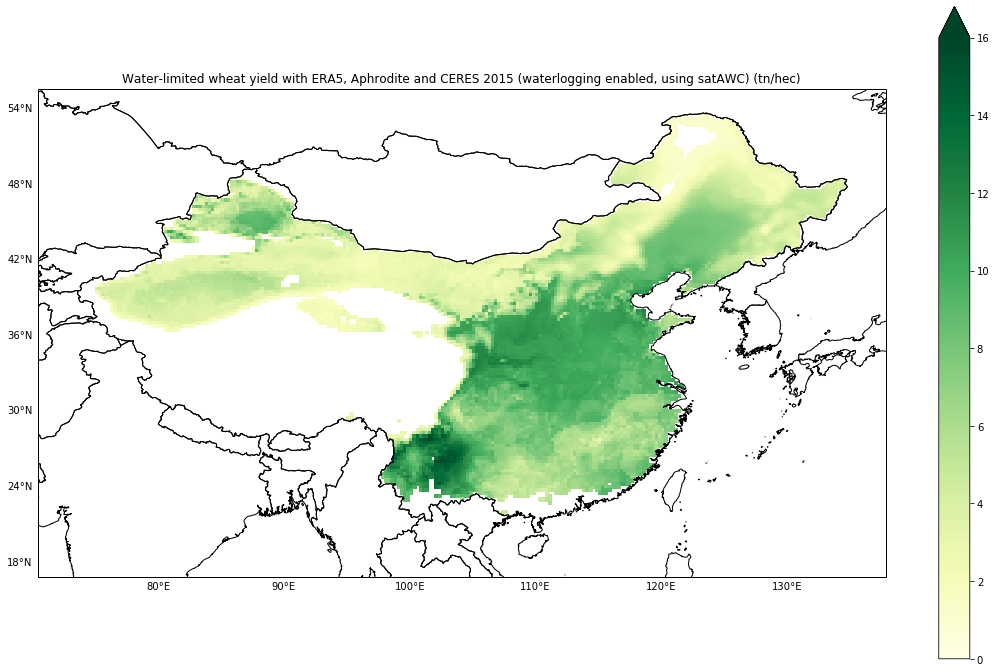

In [279]:
sfname = shapereader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')

yieldswheat = xr.load_dataarray('/prj/verdant/matbro/wheat_WLyield_era5_aphrodite_ceres_waterlogging_satAWC.nc')

yieldsceres = yieldswheat.where(yieldswheat>0)

maskedyield = catchment_subset_shapefile(data=yieldsceres, sfname=sfname, IDname='ADMIN', IDs=['China'])

ax = plt.axes(projection=cp.crs.PlateCarree())
countries = cp.feature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m', edgecolor='black', facecolor='none')
ax.add_feature(countries)
maskedyield.plot(cmap='YlGn', vmin=0, vmax=16)
gl = ax.gridlines(crs=cp.crs.PlateCarree(), draw_labels=True, alpha=0)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = cp.mpl.gridliner.LONGITUDE_FORMATTER
gl.yformatter = cp.mpl.gridliner.LATITUDE_FORMATTER
plt.title('Water-limited wheat yield with ERA5, Aphrodite and CERES 2015 (waterlogging enabled, using satAWC) (tn/hec)')
plt.savefig('/prj/verdant/matbro/plots/wheat_WLyield_era5_aphrodite_ceresini.png', dpi=300)

Found: China
Adding mask to xarray


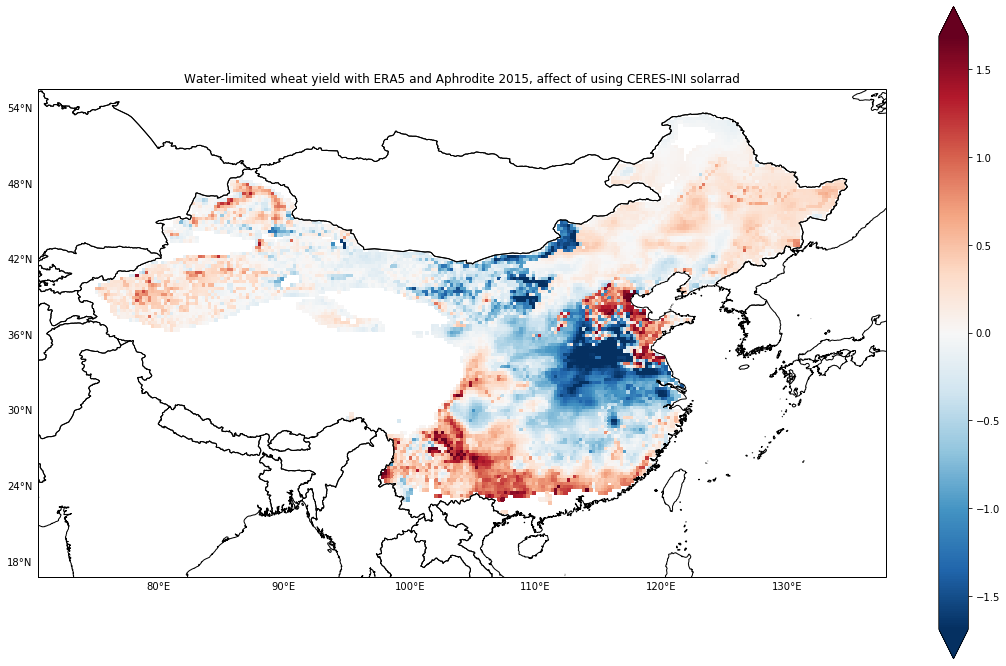

In [282]:
pcdiff = ((yieldsceres - yieldsnc)/yieldsnc)*100
diff = (yieldsceres - yieldsnc)
maskedyield = catchment_subset_shapefile(data=diff, sfname=sfname, IDname='ADMIN', IDs=['China'])
ax = plt.axes(projection=cp.crs.PlateCarree())
countries = cp.feature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m', edgecolor='black', facecolor='none')
ax.add_feature(countries)
maskedyield.plot(robust=True)
gl = ax.gridlines(crs=cp.crs.PlateCarree(), draw_labels=True, alpha=0)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = cp.mpl.gridliner.LONGITUDE_FORMATTER
gl.yformatter = cp.mpl.gridliner.LATITUDE_FORMATTER
plt.title('Water-limited wheat yield with ERA5 and Aphrodite 2015, affect of using CERES-INI solarrad')
plt.savefig('/prj/verdant/matbro/plots/affect_of_CERES-INI.png', dpi=300)

Found: China
Adding mask to xarray


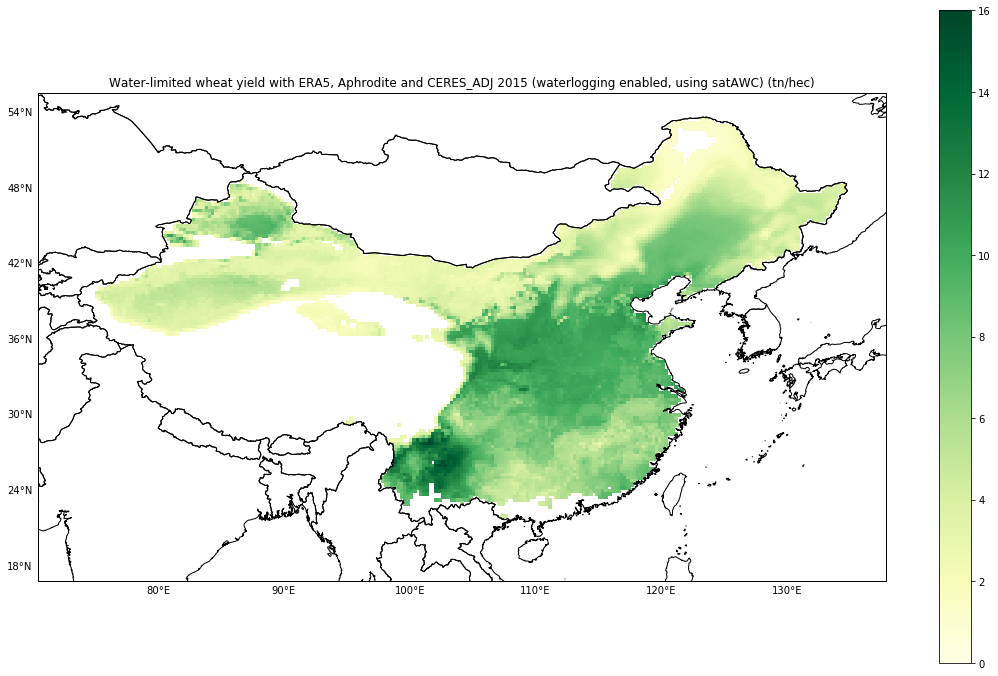

In [283]:
sfname = shapereader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')

yieldswheat = xr.load_dataarray('/prj/verdant/matbro/wheat_WLyield_era5_aphrodite_ceresadj_waterlogging_satAWC.nc')

yieldsceresadj = yieldswheat.where(yieldswheat>0)

maskedyield = catchment_subset_shapefile(data=yieldsceresadj, sfname=sfname, IDname='ADMIN', IDs=['China'])

ax = plt.axes(projection=cp.crs.PlateCarree())
countries = cp.feature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m', edgecolor='black', facecolor='none')
ax.add_feature(countries)
maskedyield.plot(cmap='YlGn', vmin=0, vmax=16)
gl = ax.gridlines(crs=cp.crs.PlateCarree(), draw_labels=True, alpha=0)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = cp.mpl.gridliner.LONGITUDE_FORMATTER
gl.yformatter = cp.mpl.gridliner.LATITUDE_FORMATTER
plt.title('Water-limited wheat yield with ERA5, Aphrodite and CERES_ADJ 2015 (waterlogging enabled, using satAWC) (tn/hec)')
plt.savefig('/prj/verdant/matbro/plots/wheat_WLYield_era5_aphrodite_ceresadj_china.png', dpi=300)

Found: China
Adding mask to xarray


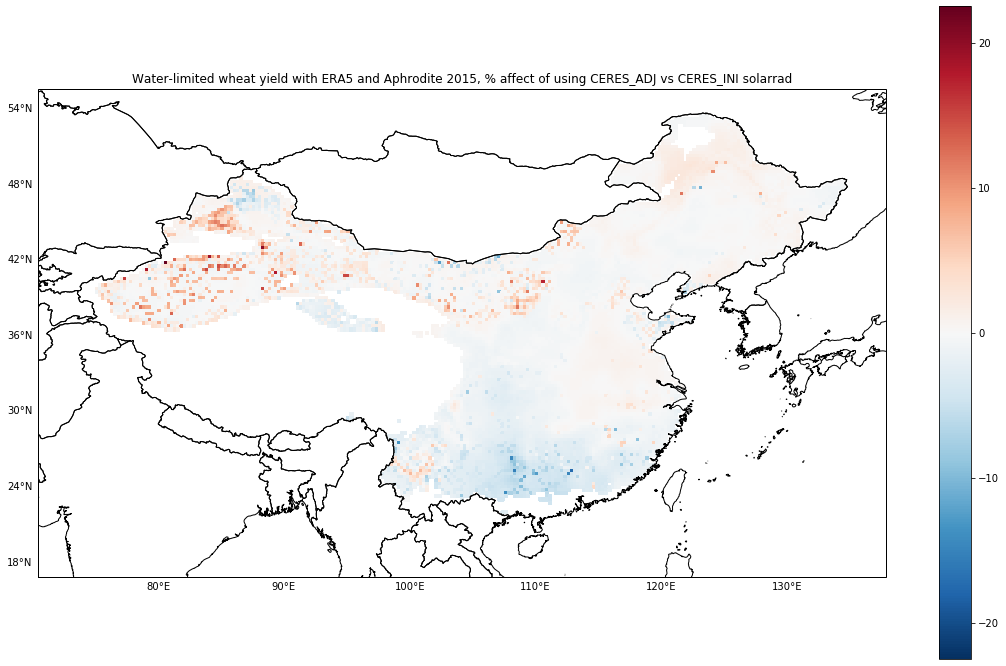

In [286]:
pcdiff = ((yieldsceresadj - yieldsceres)/yieldsceres)*100
diff = (yieldsceresadj - yieldsceres)
maskedyield = catchment_subset_shapefile(data=pcdiff, sfname=sfname, IDname='ADMIN', IDs=['China'])
ax = plt.axes(projection=cp.crs.PlateCarree())
countries = cp.feature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m', edgecolor='black', facecolor='none')
ax.add_feature(countries)
maskedyield.plot()
gl = ax.gridlines(crs=cp.crs.PlateCarree(), draw_labels=True, alpha=0)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = cp.mpl.gridliner.LONGITUDE_FORMATTER
gl.yformatter = cp.mpl.gridliner.LATITUDE_FORMATTER
plt.title('Water-limited wheat yield with ERA5 and Aphrodite 2015, % affect of using CERES_ADJ vs CERES_INI solarrad')
plt.savefig('/prj/verdant/matbro/plots/WLYield_CERESini_v_adj_pc.png', dpi=300)

Found: China
Adding mask to xarray


Text(0.5, 1.0, 'Water-limited wheat yield with ERA5, Aphrodite and satAWC 2015, % affect of using CERES_ADJ')

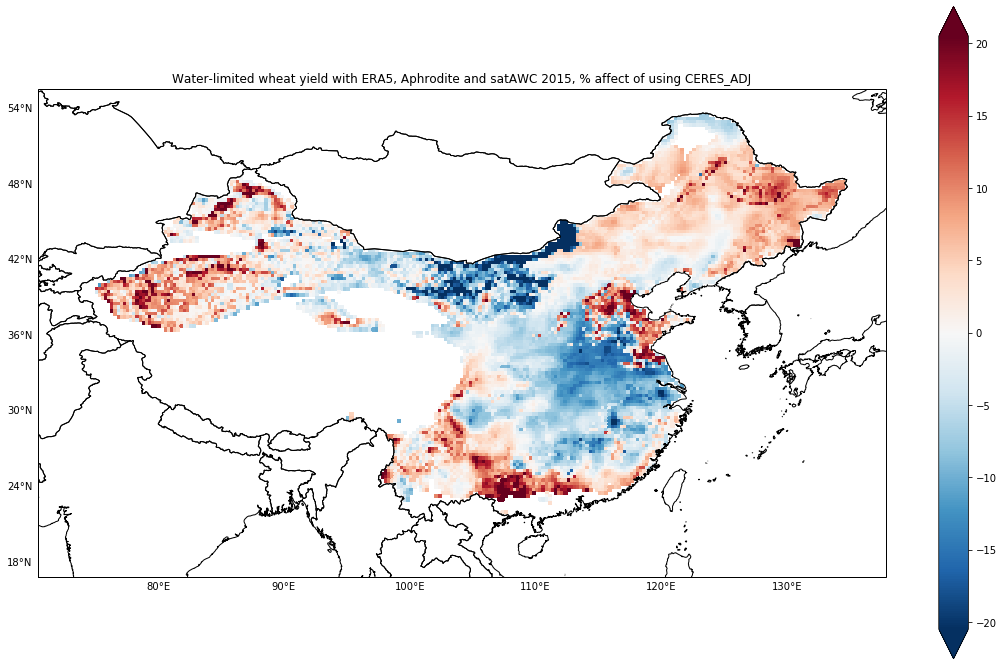

In [293]:
pcdiff = ((yieldsceresadj - yieldsnc)/yieldsnc)*100
diff = (yieldsceresadj - yieldsnc)
maskedyield = catchment_subset_shapefile(data=pcdiff, sfname=sfname, IDname='ADMIN', IDs=['China'])
ax = plt.axes(projection=cp.crs.PlateCarree())
countries = cp.feature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m', edgecolor='black', facecolor='none')
ax.add_feature(countries)
maskedyield.plot(robust=True)
gl = ax.gridlines(crs=cp.crs.PlateCarree(), draw_labels=True, alpha=0)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = cp.mpl.gridliner.LONGITUDE_FORMATTER
gl.yformatter = cp.mpl.gridliner.LATITUDE_FORMATTER
plt.title('Water-limited wheat yield with ERA5, Aphrodite and satAWC 2015, % affect of using CERES_ADJ')
#plt.savefig('/prj/verdant/matbro/plots/WLYield_affect_of_CERES_ADJ.png', dpi=300)

Found: China
Adding mask to xarray


Text(0.5, 1.0, 'Water-limited wheat yield with ERA5, Aphrodite and CERES_ADJ 2015 (waterlogging enabled, using satAWC and cropmap) (tn/hec)')

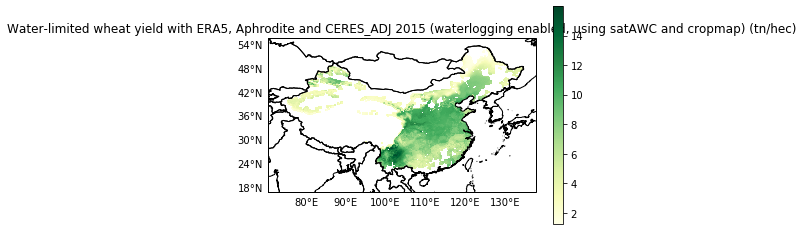

In [2]:
sfname = shapereader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')

yieldswheat = xr.load_dataarray('/prj/verdant/matbro/wheat_WLyield_era5_aphrodite_ceres_waterlogging_satAWC_cropmap.nc')

yieldscropmap = yieldswheat.where(yieldswheat>0)

maskedyield = country_subset_shapefile(data=yieldscropmap, sfname=sfname, IDname='ADMIN', IDs=['China'])

ax = plt.axes(projection=cp.crs.PlateCarree())
countries = cp.feature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m', edgecolor='black', facecolor='none')
ax.add_feature(countries)
maskedyield.plot(cmap='YlGn')
gl = ax.gridlines(crs=cp.crs.PlateCarree(), draw_labels=True, alpha=0)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = cp.mpl.gridliner.LONGITUDE_FORMATTER
gl.yformatter = cp.mpl.gridliner.LATITUDE_FORMATTER
plt.title('Water-limited wheat yield with ERA5, Aphrodite and CERES_ADJ 2015 (waterlogging enabled, using satAWC and cropmap) (tn/hec)')
#plt.savefig('/prj/verdant/matbro/plots/wheat_WLYield_era5_aphrodite_ceresadj_china.png', dpi=300)

Found: China
Adding mask to xarray


Text(0.5, 1.0, 'Wheat yield with ERA5, Aphrodite and CERES_ADJ 2015 (waterlogging enabled, using satAWC, cropmap & irrigation) (tn/hec)')

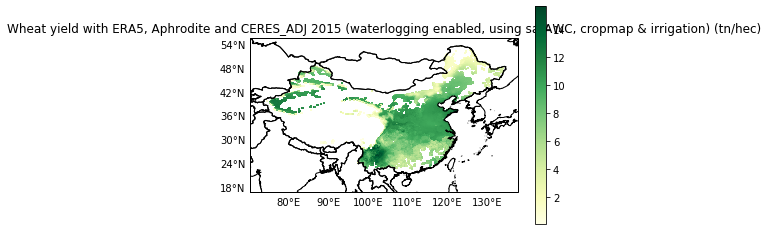

In [3]:
sfname = shapereader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')

yieldswheat = xr.load_dataarray('/prj/verdant/matbro/wheat_yield_era5_aphrodite_ceres_waterlogging_satAWC_cropmap_irr.nc')

yieldscropmapirr = yieldswheat.where(yieldswheat>0)

maskedyield = catchment_subset_shapefile(data=yieldscropmapirr, sfname=sfname, IDname='ADMIN', IDs=['China'])

ax = plt.axes(projection=cp.crs.PlateCarree())
countries = cp.feature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m', edgecolor='black', facecolor='none')
ax.add_feature(countries)
maskedyield.plot(cmap='YlGn')
gl = ax.gridlines(crs=cp.crs.PlateCarree(), draw_labels=True, alpha=0)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = cp.mpl.gridliner.LONGITUDE_FORMATTER
gl.yformatter = cp.mpl.gridliner.LATITUDE_FORMATTER
plt.title('Wheat yield with ERA5, Aphrodite and CERES_ADJ 2015 (waterlogging enabled, using satAWC, cropmap & irrigation) (tn/hec)')
#plt.savefig('/prj/verdant/matbro/plots/wheat_WLYield_era5_aphrodite_ceresadj_china.png', dpi=300)

Found: China
Adding mask to xarray


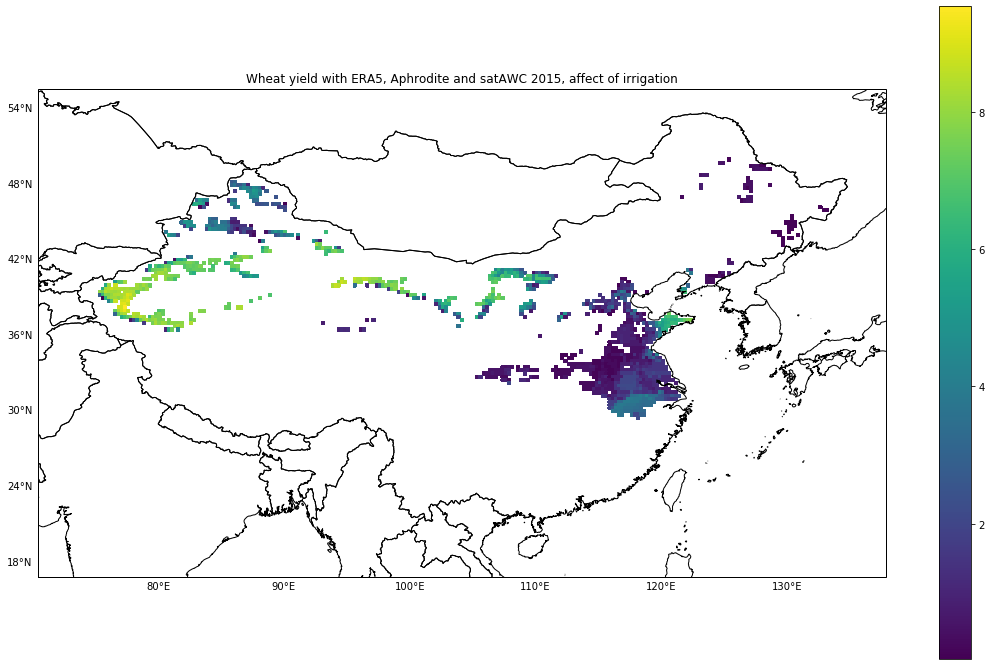

In [289]:
maskedyield = catchment_subset_shapefile(data=(yieldscropmapirr - yieldscropmap), sfname=sfname, IDname='ADMIN', IDs=['China'])
ax = plt.axes(projection=cp.crs.PlateCarree())
countries = cp.feature.NaturalEarthFeature('cultural', 'admin_0_countries', '10m', edgecolor='black', facecolor='none')
ax.add_feature(countries)
maskedyield.where(maskedyield > 0).plot()
gl = ax.gridlines(crs=cp.crs.PlateCarree(), draw_labels=True, alpha=0)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = cp.mpl.gridliner.LONGITUDE_FORMATTER
gl.yformatter = cp.mpl.gridliner.LATITUDE_FORMATTER
plt.title('Wheat yield with ERA5, Aphrodite and satAWC 2015, affect of irrigation')
plt.savefig('/prj/verdant/matbro/plots/WLYield_affect_of_irr.png', dpi=300)

Found: China
Adding mask to xarray


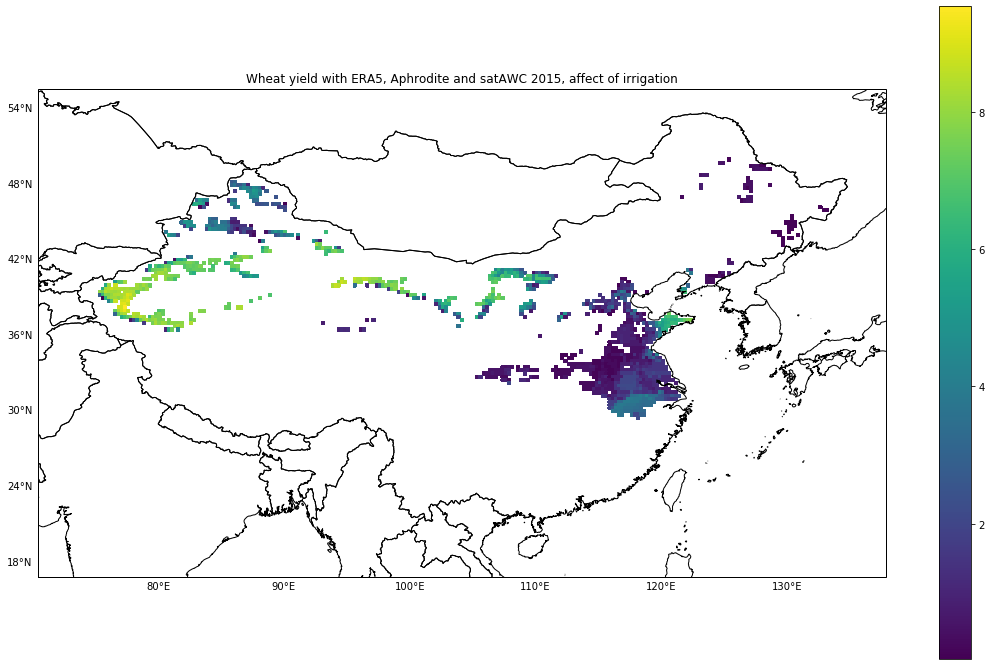

In [6]:
plt.rcParams['figure.figsize'] = [19, 12]
data = (yieldscropmapirr - yieldscropmap)
title = 'Wheat yield with ERA5, Aphrodite and satAWC 2015, affect of irrigation'
savename = '/prj/verdant/matbro/outputs/plots/WLYield_affect_of_irr.png'
spatial_plot(data, title, savename, maskval=0)